# 03 - Variação paramétrica - parte 1

UNIVERSIDADE FEDERAL DE PERNAMBUCO - CENTRO DE INFORMÁTICA

Aprendizagem de Máquina - 2025.1

- Getulio Junqueira de Queiroz Lima (gjql@cin.ufpe.br)

- Maria Beatriz Martins Pontes Goncalo (mbmpg@cin.ufpe.br)

- Rodrigo Rocha Moura (rrm2@cin.ufpe.br)

- Victor Gabriel de Carvalho (vgc3@cin.ufpe.br)

- Vinicius Gabriel Lopes Santos (vgls@cin.ufpe.br)

Este relatório aplica os modelos

* K-NN
* LVQ (Learning Vector Quantization)
* Árvore de Decisão
* SVM (Support Vector Machine)
* Random Forest

no dataset [house_16H v2](https://www.openml.org/search?type=data&sort=runs&id=821&status=active).

O [house_16H v2](https://www.openml.org/search?type=data&sort=runs&id=821&status=active) consiste em um banco de dados derivado do Censo dos EUA de 1990 e projetado para prever se imóveis em diferentes regiões estão com preços abaixo ou acima da média.

O dataset possui 16 features (por isso o número 16 no nome) e essas features possuem alta variância e pouca correlação com a variável alvo.

---

### Importando bibliotecas para a análise exploratória de dados:

Serão necessárias as seguintes bibliotecas Python para manipulação de dados, análise estatística e visualização.

- `math`: Fornece funções matemáticas.
- `pandas`: Uma biblioteca poderosa para manipulação e análise de dados.
- `sklearn.model_selection.train_test_split`: Função que particiona os dados em conjuntos de treinamento, validação e teste.
- `sklearn.model_selection.RandomizedSearchCV`: Método de busca de hiperparâmetros.
- `sklearn.model_selection.StratifiedKFold`: Para validação cruzada estratificada.
- `sklearn.preprocessing.LabelEncoder`: Função que aplica o one-hot encoding na variável-alvo $binaryClass$.
- `sklearn.preprocessing.MinMaxScaler`: Função que aplica normalização de dados.
- `scipy.io.arff`: Usado para carregar dados de arquivos ARFF.
- `scipy.stats.zscore`: Usado para calcular o z-score para detecção de outliers.
- `scipy.stats.expon`: Variável aleatória contínua exponencial.
- `scipy.stats.loguniform`: Variável aleatória contínua loguniform.
- `seaborn`: Uma biblioteca de visualização de dados estatísticos baseada em Matplotlib.
- `matplotlib.pyplot`: Uma biblioteca de plotagem para criar visualizações estáticas, interativas e animadas em Python.
- `imblearn.over_sampling.SMOTE`: Técnica de reamostragem para equilibrar classes desbalanceadas.
- `sklearn.neighbors.KNeighborsClassifier`: Implementação do K-NN.
- `sklvq`: Implementação do LVQ.
- `sklearn.tree.DecisionTreeClassifier`: Implementação da Árvore de Decisão.
- `sklearn.svm`: Implementação do SVM.
- `sklearn.ensemble.RandomForestClassifier`: Implementação da Random Forest.
- `random_seed`: Definindo um random_seed para todos os processos aleatórios.
- `sklearn.metrics.accuracy_score`: Calcula a acurácia do modelo, ou seja, a proporção de previsões corretas em relação ao total de amostras.
- `sklearn.metrics.precision_score`: Calcula precisão do modelo, ou seja, a proporção de verdadeiros positivos entre todas as previsões positivas.
- `sklearn.metrics.recall_score`: Mede o recall do modelo, ou seja, a proporção de verdadeiros positivos entre todos os casos realmente positivos.
- `sklearn.metrics.f1_score`: Calcula a média harmônica entre precisão e recall, equilibrando ambos.
- `sklearn.metrics.roc_auc_score`: Mede a área sob a curva ROC, indicando o desempenho do modelo em diferentes thresholds.
- `sklearn.metrics.confusion_matrix`: Gera a matriz de confusão do modelo, isto é, uma matriz com contagens de verdadeiros/ falsos positivos e negativos.
- `sklearn.metrics.classification_report`: Fornece um resumo com precisão, recall, F1-score e suporte para cada classe.

In [ ]:
!pip install sklvq -U -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 853.3 kB/s eta 0:00:00


In [ ]:
import math
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from scipy.io import arff
from scipy.stats import zscore, expon, loguniform

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier
from sklvq import GLVQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


random_seed = 9

### Baixando o arquivo em [house_16H v2](https://www.openml.org/search?type=data&sort=runs&id=821&status=active):

É necessário baixar o conjunto de dados `house_16H.arff` da URL OpenML especificada usando o comando `wget`. A saída mostra o progresso e a confirmação do download. No total, temos um arquivo de 2.64 MB.

In [ ]:
!wget https://www.openml.org/data/download/53355/house_16H.arff

--2025-07-25 19:58:32--  https://www.openml.org/data/download/53355/house_16H.arff
Resolving www.openml.org (www.openml.org)... 131.155.10.135
Connecting to www.openml.org (www.openml.org)|131.155.10.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2773353 (2.6M) [text/plain]
Saving to: ‘house_16H.arff’

house_16H.arff      100%[===================>]   2.64M  1.75MB/s    in 1.5s    

2025-07-25 19:58:35 (1.75 MB/s) - ‘house_16H.arff’ saved [2773353/2773353]



---

### Lendo o arquivo do dataset:

Como os dados estão em formato ARFF, é necessário utilizar a função `scipy.io.arff.loadarff` para ler o arquivo e gerar em um DataFrame do Pandas.

In [ ]:
arff_file = arff.loadarff('/content/house_16H.arff')
df = pd.DataFrame(arff_file[0])

### Visualizando o cabeçalho e as primeiras linhas do dataset:

Abaixo estão as 5 primeiras linhas do DataFrame, exibidas usando o método `df.head()`. Isso fornece uma visualização rápida dos dados, mostrando os nomes das colunas e os valores iniciais.

In [ ]:
df.head()

P1      P5p1      P6p2     P11p4     P14p9     P15p1     P15p3  \
0  15512.0  0.460869  0.049252  0.226470  0.149827  0.752837  0.010057   
1   1550.0  0.470968  0.002581  0.137419  0.096342  0.862581  0.000000   
2   4741.0  0.485341  0.000211  0.189412  0.135656  0.856992  0.000000   
3    467.0  0.498929  0.000000  0.100642  0.085470  0.907923  0.000000   
4    310.0  0.474194  0.680645  0.225807  0.128834  0.896774  0.000000   

      P16p2     P18p2     P27p4      H2p2      H8p2     H10p1     H13p1  \
0  0.579729  0.003251  0.075912  0.625318  0.036613  0.991377  0.260116   
1  0.695142  0.005025  0.043551  0.064263  0.003350  0.994975  0.285267   
2  0.683584  0.004143  0.027965  0.065796  0.000000  0.997411  0.315433   
3  0.780488  0.006098  0.018293  0.057471  0.000000  1.000000  0.149425   
4  0.756303  0.008403  0.016807  0.077519  0.672269  0.991597  0.147287   

      H18pA     H40p4 binaryClass  
0  0.052246  0.774059        b'N'  
1  0.060606  0.142857        b'P'  
2  0.065116  0.687500        b'P'  
3  0.139535  1.000000        b'P'  
4  0.000000  0.000000        b'P'

A partir da tabela acima, já podemos observar que:

- realmente temos 16 variáveis: $P1$, $P5p1$, $P6p2$, $P11p4$, $P14p9$, $P15p1$, $P15p3$, $P16p2$, $P18p2$, $P27p4$, $H2p2$, $H8p2$, $H10p1$, $H13p1$, $H18pA$ e $H40p4$, conforme observado anteriormente.

- Todas essas 16 features parecem ser contínuas possuir escalas de valores diferentes entre sí. Portanto, ao aplicar, posteriormente, os modelos de aprendizagem de máquina, precisaremos normalizar os dados.

- A variável target, chamada de $binaryClass$, é categórica. Desse modo, precisaremos, posteriormente, transformá-la em variável numérica para a aplicação de modelos de aprendizagem de máquina.

---

## Compreensão dos Dados

### Resumo geral do dataset:

É interessante imprimir um resumo do DataFrame, usando `df.info()`, que inclui os nomes das colunas, o número de valores não nulos, os tipos de dados de cada coluna e o tamannho do dataset. A saída confirma a forma e os tipos de dados vistas anteriormente.

In [ ]:
print("\nTipos de dados e contagem de valores não nulos por coluna:")
print(df.info())
print(f"Dimensões do DataFrame: {df.shape}")


Tipos de dados e contagem de valores não nulos por coluna:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22784 entries, 0 to 22783
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   P1           22784 non-null  float64
 1   P5p1         22784 non-null  float64
 2   P6p2         22784 non-null  float64
 3   P11p4        22784 non-null  float64
 4   P14p9        22784 non-null  float64
 5   P15p1        22784 non-null  float64
 6   P15p3        22784 non-null  float64
 7   P16p2        22784 non-null  float64
 8   P18p2        22784 non-null  float64
 9   P27p4        22784 non-null  float64
 10  H2p2         22784 non-null  float64
 11  H8p2         22784 non-null  float64
 12  H10p1        22784 non-null  float64
 13  H13p1        22784 non-null  float64
 14  H18pA        22784 non-null  float64
 15  H40p4        22784 non-null  float64
 16  binaryClass  22784 non-null  object 
dtypes: float64(16), object(1)
me

Conforme o resultado acima, temos originalmente 22784 amostras no dataset [house_16H v2](https://www.openml.org/search?type=data&sort=runs&id=821&status=active), cada uma com 16 features e um valor da label. Também, conforme a tabela acima, todas as 16 features são compostas por números reais. A variável target é categórica e aparece como do tipo *object*.

### Breve resumo estatístico de cada uma das features e do target:

Segundo a [documentação original](https://www.cs.toronto.edu/~delve/data/census-house/) do dataset, cada coluna significa:

- **binaryClass** (target): Preço mediano do imóvel na região (variável alvo).
- **P1**: Número total de pessoas na região.
- **P5p1**: Percentual de homens na população (P5.1 na descrição original).
- **P6p2**: Percentual de pessoas negras na população (P6.2 na descrição original).
- **P11p4**: Percentual de pessoas com mais de 64 anos (P11.4 na descrição original).
- **P14p9**: Percentual de mulheres viúvas (P14.9 na descrição original).
- **P15p1**: Percentual de pessoas que moram em domicílios familiares (P15.1 na descrição original).
- **P15p3**: Percentual de pessoas que moram em instituições coletivas (ex.: prisões) (P15.3 na descrição original).
- **P16p2**: Percentual de domicílios com 2 pessoas ou mais que são famíliares (P16.2 na descrição original).
- **P18p2**: Percentual de domicílios com 1 menor ou mais que não é familiar (menor possui idade < 18 anos) (P18.2 na descrição original).
- **P27p4**: Percentual de domicílios com 2 pessoas ou mais que não são familiares (P27.4 na descrição original).
- **H2p2**: Percentual de unidades habitacionais vagas (H2.2 na descrição original).
- **H8p2**: Percentual de unidades habitacionais ocupadas com chefe de família negro (H8.2 na descrição original).
- **H10p1**: Percentual de unidades habitacionais ocupadas com chefe de família não hispânico (H10.1 na descrição original).
- **H13p1**: Percentual de unidades habitacionais com 1-4 cômodos (H13.1 na descrição original).
- **H18pA**: Número médio de pessoas por unidade habitacional ocupada pelo proprietário (H18.A na descrição original).
- **H40p4**: Percentual de unidades habitacionais que estão simultaneamente vagas e à venda, mas que estão vagas há mais de 6 meses (H40.4 na descrição original).

Podemos, também, gerar estatísticas descritivas para as variáveis contínuas no DataFrame usando `df.describe()`. O `.T` apenas transpõe a saída para melhor legibilidade, exibindo estatísticas como contagem, média, desvio padrão, mínimo, máximo e quartis para cada característica contínua.

In [ ]:
df.describe().T

count         mean           std       min         25%          50%  \
P1     22784.0  7808.669198  65872.423580  2.000000  427.000000  1345.500000   
P5p1   22784.0     0.482297      0.031876  0.125000    0.464647     0.480397   
P6p2   22784.0     0.063982      0.150921  0.000000    0.000000     0.003413   
P11p4  22784.0     0.163900      0.080461  0.000000    0.112069     0.155484   
P14p9  22784.0     0.121538      0.056687  0.000000    0.081236     0.117126   
P15p1  22784.0     0.851076      0.079455  0.054156    0.819686     0.863645   
P15p3  22784.0     0.020487      0.057666  0.000000    0.000000     0.000000   
P16p2  22784.0     0.716131      0.087264  0.233702    0.662283     0.714286   
P18p2  22784.0     0.003589      0.005100  0.000000    0.000000     0.002591   
P27p4  22784.0     0.033263      0.029567  0.000000    0.016260     0.027523   
H2p2   22784.0     0.110527      0.105925  0.000000    0.049303     0.081180   
H8p2   22784.0     0.057437      0.139811  0.000000    0.000000     0.002538   
H10p1  22784.0     0.967045      0.099953  0.003257    0.981410     0.994100   
H13p1  22784.0     0.304993      0.133998  0.000000    0.221674     0.299800   
H18pA  22784.0     0.107377      0.090065  0.000000    0.052770     0.086957   
H40p4  22784.0     0.491626      0.331655  0.000000    0.243243     0.500000   

               75%           max  
P1     4518.250000  7.322564e+06  
P5p1      0.496040  9.230770e-01  
P6p2      0.033377  1.000000e+00  
P11p4     0.203596  9.172550e-01  
P14p9     0.156757  5.118720e-01  
P15p1     0.899657  1.000000e+00  
P15p3     0.019196  9.433250e-01  
P16p2     0.771039  1.000000e+00  
P18p2     0.005007  1.250000e-01  
P27p4     0.042827  7.057360e-01  
H2p2      0.131430  9.751770e-01  
H8p2      0.029927  1.000000e+00  
H10p1     1.000000  1.000000e+00  
H13p1     0.375000  1.000000e+00  
H18pA     0.137931  1.000000e+00  
H40p4     0.750000  1.000000e+00

Assim como antes, podemos gerar estatísticas descritivas para as variáveis categóricas no DataFrame usando `df.describe(include=['object'])`. Ele mostra a contagem, o número de valores únicos, o valor mais frequente e sua frequência para a coluna 'binaryClass', indicando que ela possui dois valores únicos e mostrando a distribuição.

In [ ]:
df.describe(include=['object']).T

count unique   top   freq
binaryClass  22784      2  b'P'  16040

Das tabelas acima, podemos observar que:

* A variável $P1$ possui o maior valor médio dentre todas as 16 features, $7808,669$, e parece ter o maior intervalo de valores. As demais variáveis estão todas com valores positivos e menores que 1.

* A variável $P18p2$ possui o menor valor médio dentre todas as 16 features: $0.003589$

* As seguintes variáveis possuem valores médios semelhantes:
 * $P5p1$, $H13p1$ e $H40p4$
 * $P6p2$ e $H8p2$
 * $P11p4$, $P14p9$, $H2p2$ e $H18pA$
 * $P15p1$, $P16p2$ e $H10p1$

* A variável $P1$ possui o maior desvio padrão dentre todas as 16 features: $65872.42$

* A variável $P18p2$ possui o menor desvio padrão dentre todas as 16 features: $0.005100$

* As seguintes variáveis possuem valores de desvio padrão semelhantes:
 * $P5p1$ e $P27p4$
 * $P6p2$, $H8p2$ e $H13p1$
 * $P11p4$, $P15p1$, $P16p2$, $H10p1$ e $H18pA$
 * $P14p9$ e $P15p3$




---

### Checando se há valores ausentes:

Verificamos o número total de valores ausentes no DataFrame somando os valores nulos em todas as colunas usando `df.isnull().sum().sum()`.

In [ ]:
missing_data = df.isnull().sum().sum()
print("Quantidade de dados ausentes:", missing_data)

Quantidade de dados ausentes: 0


### Checando se há valores duplicados

In [ ]:
duplicates = df.duplicated().sum()
print("Quantidade de dados duplicados:", duplicates)

Quantidade de dados duplicados: 1


In [ ]:
df.drop_duplicates(inplace=True)

duplicates = df.duplicated().sum()
print("Quantidade de dados duplicados:", duplicates)

Quantidade de dados duplicados: 0


---

É necessário dividir colunas do DataFrame em listas contínuas, categóricas e booleanas com base em seus tipos de dados usando `select_dtypes`. Diferentes tipos de valores necessitarão de diferentes tratamentos. Abaixo temos as listas de colunas para cada categoria.

In [ ]:
continuous_vars = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()
bool_vars = df.select_dtypes(include=['bool']).columns.tolist()

print("Variáveis contínuas:", continuous_vars)
print("Variáveis categóricas:", categorical_vars)
print("Variáveis booleanas:", bool_vars)

Variáveis contínuas: ['P1', 'P5p1', 'P6p2', 'P11p4', 'P14p9', 'P15p1', 'P15p3', 'P16p2', 'P18p2', 'P27p4', 'H2p2', 'H8p2', 'H10p1', 'H13p1', 'H18pA', 'H40p4']
Variáveis categóricas: ['binaryClass']
Variáveis booleanas: []


Conforme o resultado acima, não há nenhum valor nulo no dataset.

---

### Distribuição nas 16 features:

Para observarmos melhor a distribuição dos dados, geramos histogramas para cada variável contínua. Assim como acima, criamos dois histogramas por variável: um mostrando a distribuição geral e outro mostrando a distribuição dividida pelas categorias "binaryClass". Os histogramas mostram a distribuição de frequência dos valores para cada variável e ajudam a entender o formato da distribuição (por exemplo, normal, assimétrica) e como ela varia entre as classes.

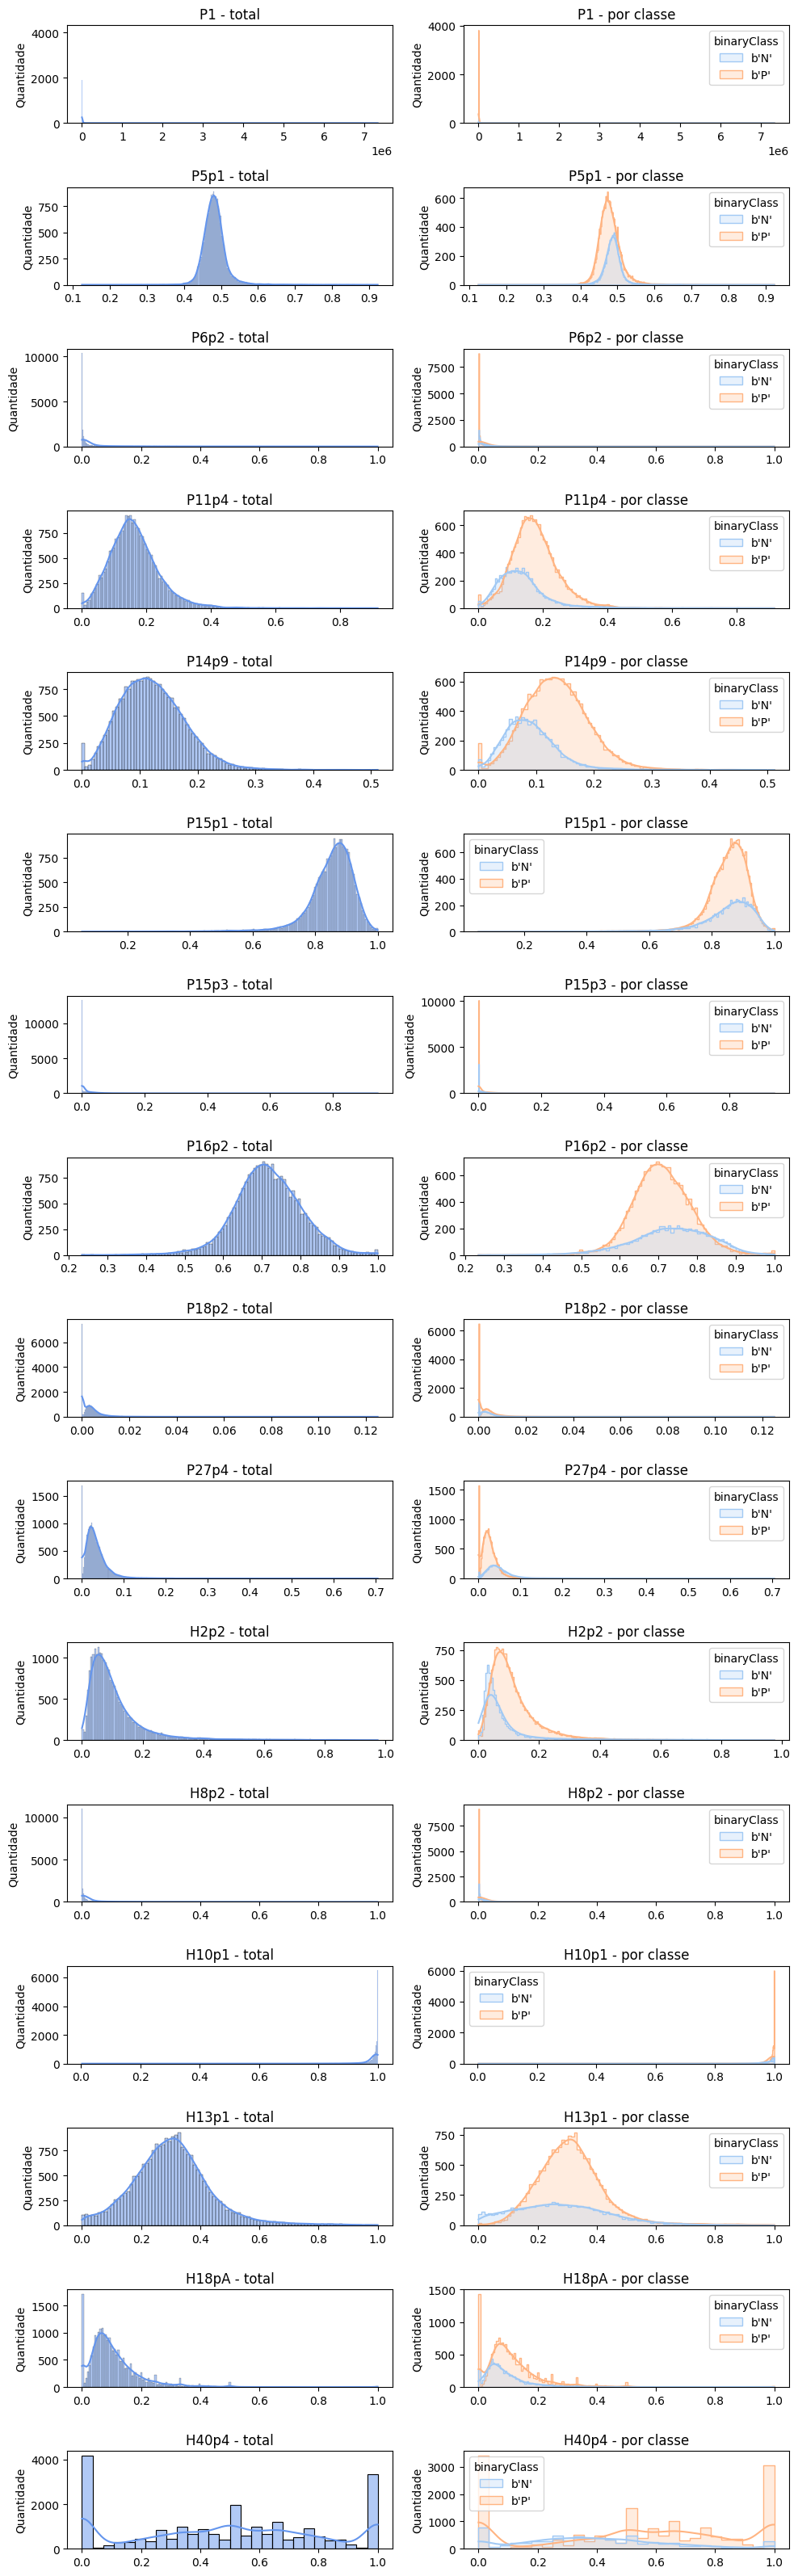

In [ ]:
num_vars = len(continuous_vars)
cols = 2
rows = num_vars

fig, axes = plt.subplots(rows, cols, figsize=(10, 2 * rows))
axes = axes.reshape(rows, cols)

for i, col in enumerate(continuous_vars):

    sns.histplot(
        data=df,
        x=col,
        kde=True,
        color='cornflowerblue',
        ax=axes[i, 0]
    )
    axes[i, 0].set_title(f"{col} - total")
    axes[i, 0].set_ylabel("Quantidade")

    sns.histplot(
        data=df,
        x=col,
        hue=categorical_vars[0],
        kde=True,
        palette='pastel',
        element='step',
        stat='count',
        common_norm=False,
        ax=axes[i, 1]
    )
    axes[i, 1].set_title(f"{col} - por classe")
    axes[i, 1].set_ylabel("Quantidade")

    axes[i, 0].set_xlabel('')
    axes[i, 1].set_xlabel('')

plt.tight_layout()
plt.show()


Com base nos histogramas:

- P1: A distribuição de P1 (número total de pessoas) é altamente assimétrica à direita, com uma grande concentração de valores na extremidade inferior e uma cauda longa que se estende em direção aos valores mais altos. Isso é evidente tanto na distribuição total quanto nas distribuições por classe. A classe 'P' parece ter uma frequência maior de valores mais baixos de P1 em comparação com a classe 'N'.

- P5p1: A distribuição de P5p1 (porcentagem de homens) parece ter uma distribuição relativamente normal, centrada em torno de 0,48, com um pico discreto. As distribuições para ambas as classes são semelhantes em formato, embora possa haver diferenças sutis no pico ou na dispersão.

- P6p2: A distribuição de P6p2 (porcentagem de negros) é fortemente assimétrica em direção a zero, indicando que a maioria das regiões tem uma porcentagem muito baixa de negros. Há uma cauda longa que se estende em direção a porcentagens mais altas. A distribuição para a classe 'P' é ainda mais concentrada em zero do que para a classe 'N'.

- P11p4: A distribuição de P11p4 (percentual de pessoas com mais de 64 anos) apresenta um pico em torno de 0,15-0,20. As distribuições para ambas as classes são relativamente semelhantes em forma, mas pode haver diferenças na altura e na localização exata do pico.

- P14p9: A distribuição de P14p9 (percentual de mulheres viúvas) também é assimétrica à direita, com concentração de valores na extremidade inferior. As distribuições para ambas as classes apresentam um padrão semelhante de assimetria.

- P15p1: A distribuição de P15p1 (percentual de pessoas em domicílios familiares) é assimétrica à esquerda, com concentração de valores na extremidade superior (mais próxima de 1). Ambas as classes apresentam essa assimetria à esquerda.

- P15p3: A distribuição de P15p3 (percentual de pessoas em instituições coletivas) é altamente concentrada em zero, indicando que a maioria das regiões possui um percentual muito baixo de pessoas em instituições coletivas. Semelhante a P6p2, a distribuição para a classe 'P' é mais concentrada em zero do que para a classe 'N'.

- P16p2: A distribuição de P16p2 (porcentagem de domicílios com 2 ou mais membros da família) parece ter uma distribuição relativamente normal, com um pico em torno de 0,7. As distribuições para ambas as classes são semelhantes em formato.

- P18p2: A distribuição de P18p2 (porcentagem de domicílios com 1 ou mais membros menores não familiares) é fortemente assimétrica em direção a zero, indicando que a maioria das regiões possui uma porcentagem muito baixa desses domicílios. Ambas as classes apresentam essa forte assimetria em direção a zero.

- P27p4: A distribuição de P27p4 (porcentagem de domicílios com 2 ou mais membros não familiares) também é assimétrica em direção a zero, com uma cauda longa que se estende para a direita. Ambas as classes apresentam um padrão semelhante de assimetria.

- H2p2: A distribuição de H2p2 (porcentagem de unidades habitacionais vagas) é assimétrica para a direita, com uma concentração de valores na extremidade inferior. Ambas as classes apresentam essa assimetria para a direita.

- H8p2: A distribuição de H8p2 (porcentagem de unidades ocupadas com chefes de família negros) é fortemente assimétrica para zero, semelhante à de P6p2. A distribuição para a classe 'P' é mais concentrada em zero do que para a classe 'N'. Essa forte correlação entre P6p2 e H8p2 também se reflete em seus formatos de histograma semelhantes.

- H10p1: A distribuição de H10p1 (porcentagem de unidades ocupadas com chefes de família não hispânicos) é assimétrica para a esquerda, com uma concentração de valores na extremidade superior (mais próxima de 1). Ambas as classes apresentam essa assimetria para a esquerda.

- H13p1: A distribuição de H13p1 (porcentagem de unidades com 1 a 4 cômodos) parece apresentar distribuição relativamente normal, com um pico em torno de 0,3. As distribuições para ambas as classes apresentam formato semelhante.

- H18pA: A distribuição de H18pA (número médio de pessoas por unidade ocupada pelo proprietário) é assimétrica para a direita, com uma concentração de valores na extremidade inferior. Ambas as classes apresentam essa assimetria para a direita.

- H40p4: A distribuição de H40p4 (porcentagem de unidades vagas à venda há mais de 6 meses) parece apresentar distribuição relativamente uniforme entre 0 e 1, com um ligeiro pico em torno de 0,5. As distribuições para ambas as classes apresentam formato semelhante.

De modo geral, muitas das variáveis apresentam distribuições assimétricas, particularmente aquelas que representam porcentagens de determinados dados demográficos ou características habitacionais. Para algumas variáveis (P6p2, P15p3, H8p2), há diferenças perceptíveis nas distribuições entre as duas classes, sugerindo que essas características podem ser mais importantes para distinguir entre as classes.

---

### Detecção de Outliers e Valores Fora da Escala

Para definir o número de outliers para cada variável contínua, usamos o método z-score. Valores com um z-score maior que 3 são identificados como outliers. Abaixo mostramos o número de outliers detectados para cada atributo contínuo.

In [ ]:
outlier_info = pd.DataFrame()
for col in continuous_vars:
    z_scores = zscore(df[col].dropna())
    outliers = (abs(z_scores) > 3).sum()
    outlier_info.loc[col, 'Outliers (>3σ)'] = outliers

print("Número de outliers por variável:\n")
outlier_info

Número de outliers por variável:



Outliers (>3σ)
P1               73.0
P5p1            315.0
P6p2            715.0
P11p4           231.0
P14p9           154.0
P15p1           393.0
P15p3           413.0
P16p2           209.0
P18p2           330.0
P27p4           334.0
H2p2            520.0
H8p2            659.0
H10p1           516.0
H13p1           292.0
H18pA           411.0
H40p4             0.0

Ademais, podemos gerar boxplots para cada variável contínua. Criamos dois boxplots por variável: um mostrando a distribuição geral e outro mostrando a distribuição dividida pelas categorias "binaryClass". Isso ajuda a visualizar a distribuição, a mediana, os quartis e os potenciais valores discrepantes para cada variável e como eles diferem entre as duas classes.

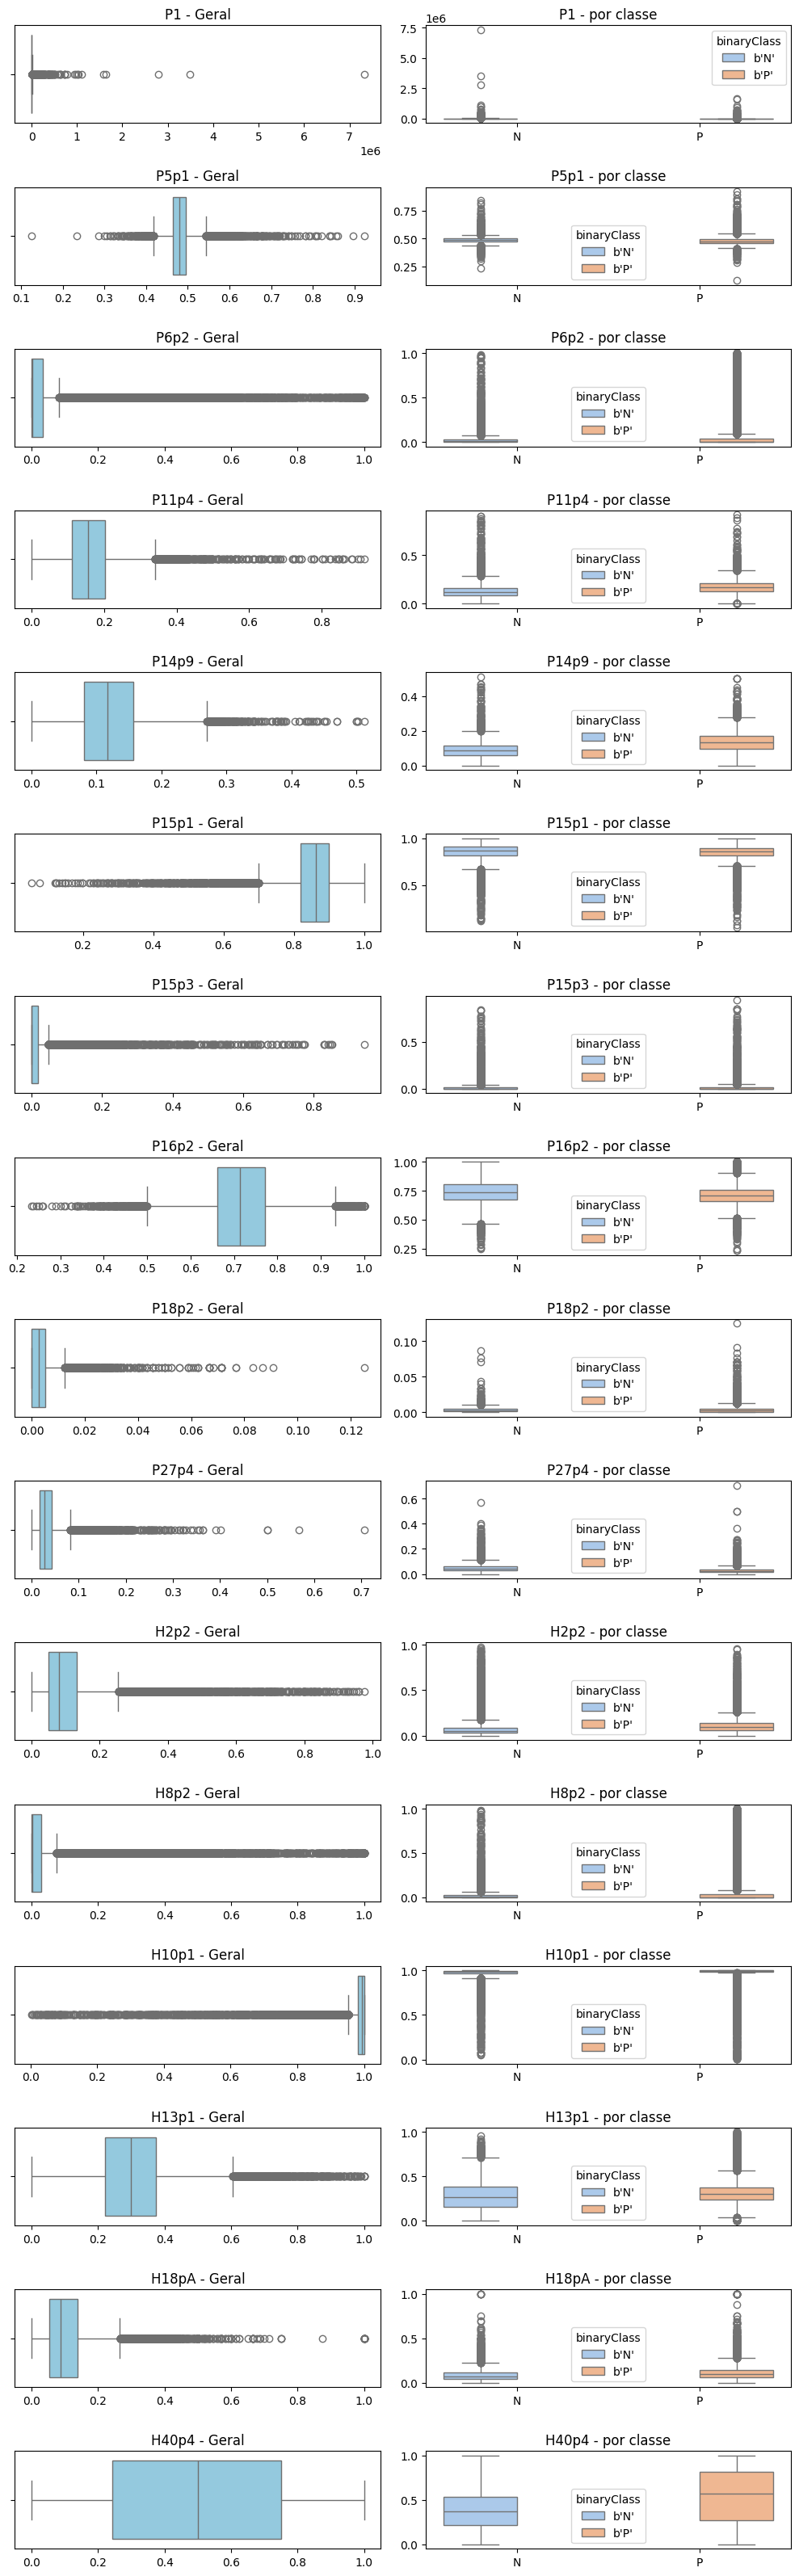

In [ ]:
num_vars = len(continuous_vars)
cols = 2
rows = num_vars

fig, axes = plt.subplots(rows, cols, figsize=(10, 2 * rows))
axes = axes.reshape(rows, cols)

for i, col in enumerate(continuous_vars):
    # Boxplot geral (sem classe)
    sns.boxplot(data=df, x=col, color='skyblue', ax=axes[i, 0])
    axes[i, 0].set_title(f'{col} - Geral')
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('')

    # Boxplot por classe (com hue)
    sns.boxplot(data=df, x=categorical_vars[0], y=col, hue=categorical_vars[0], palette='pastel', dodge=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} - por classe')
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel('')

plt.tight_layout()
plt.show()

Com base nos boxplots:

- P1: O boxplot para P1 mostra uma distribuição altamente assimétrica, com um grande número de valores discrepantes na extremidade superior. A mediana é baixa e o box se concentra nos valores mais baixos. Quando divididas por classe, ambas as classes mostram um padrão semelhante de assimetria à direita e valores discrepantes, mas a classe "P" parece ter uma mediana ligeiramente menor e menos dispersão em comparação com a classe "N".

- P5p1: O boxplot para P5p1 mostra uma distribuição relativamente simétrica, com alguns valores discrepantes em ambas as extremidades. Quando divididas por classe, os boxplots para ambas as classes são bastante semelhantes, sugerindo que a porcentagem de homens não diferencia fortemente entre as duas classes.

- P6p2: O boxplot para P6p2 é altamente assimétrico em direção a zero, com muitos valores discrepantes em valores mais altos. A maioria dos dados está agrupada perto do mínimo. O boxplot para a classe "P" é ainda mais concentrado em zero do que para a classe "N", indicando que regiões com maior percentual de negros têm maior probabilidade de pertencer à classe "N".

- P11p4: O boxplot para P11p4 mostra uma distribuição com leve assimetria à direita e alguns valores discrepantes. Os boxplots para ambas as classes são relativamente semelhantes, sugerindo que a porcentagem de pessoas com mais de 64 anos tem uma distribuição semelhante em ambas as classes.

- P14p9: O boxplot para P14p9 é assimétrico à direita com valores discrepantes. Os boxplots para ambas as classes mostram um padrão semelhante de assimetria à direita, com mediana e quartis próximos para ambas as classes.

- P15p1: O boxplot para P15p1 é assimétrico à esquerda, com a caixa e a mediana mais próximas de 1. Há valores discrepantes na extremidade inferior. Os boxplots para ambas as classes são semelhantes em forma e posição, sugerindo que a porcentagem de pessoas em domicílios familiares é distribuída de forma semelhante entre ambas as classes.

- P15p3: O boxplot para P15p3 é altamente concentrado em zero, com um número significativo de outliers em valores mais altos. Isso indica que a maioria das regiões tem uma porcentagem muito baixa de pessoas em instituições coletivas. O boxplot para a classe 'P' é mais concentrado em zero do que para a classe 'N', sugerindo que regiões com maior porcentagem de pessoas em instituições coletivas têm maior probabilidade de estar na classe 'N'.

- P16p2: O boxplot para P16p2 mostra uma distribuição relativamente simétrica com alguns outliers. Os boxplots para ambas as classes são muito semelhantes, sugerindo que a porcentagem de domicílios com 2 ou mais membros da família é distribuída de forma semelhante entre ambas as classes.

- P18p2: O boxplot para P18p2 é fortemente assimétrico em direção a zero, com muitos outliers em valores mais altos. Ambas as classes apresentam essa forte assimetria em direção a zero, indicando que domicílios com menores não familiares são raros em ambas as classes.

- P27p4: O boxplot para P27p4 é assimétrico em direção a zero com valores discrepantes. Ambas as classes apresentam um padrão semelhante de assimetria, com a maioria dos valores concentrados na extremidade inferior.

- H2p2: O boxplot para H2p2 é assimétrico à direita com valores discrepantes. Ambas as classes apresentam um padrão semelhante de assimetria à direita, com a mediana e os quartis próximos para ambas as classes.

- H8p2: O boxplot para H8p2 é fortemente assimétrico em direção a zero, semelhante ao P6p2, com muitos valores discrepantes em valores mais altos. O boxplot para a classe 'P' é mais concentrado em zero do que para a classe 'N', reforçando a observação dos histogramas de que regiões com maior porcentagem de chefes de família negros têm maior probabilidade de estar na classe 'N'.

- H10p1: O boxplot para H10p1 é assimétrico à esquerda, com a caixa e a mediana mais próximas de 1. Há valores discrepantes na extremidade inferior. Os boxplots para ambas as classes são semelhantes em forma e posição, sugerindo que a porcentagem de unidades ocupadas por chefes de família não hispânicos é distribuída de forma semelhante entre ambas as classes.

- H13p1: O boxplot para H13p1 parece relativamente simétrico, com alguns valores discrepantes. Os boxplots para ambas as classes são bastante semelhantes, sugerindo que a porcentagem de unidades com 1 a 4 cômodos é distribuída de forma semelhante entre ambas as classes.

- H18pA: O boxplot para H18pA é assimétrico à direita, com valores discrepantes. Ambas as classes apresentam um padrão semelhante de assimetria à direita, com a mediana e os quartis próximos para ambas as classes.

- H40p4: O boxplot para H40p4 parece relativamente simétrico, com alguns valores discrepantes. Os boxplots para ambas as classes são bastante semelhantes, sugerindo que a porcentagem de unidades vagas à venda há mais de 6 meses é distribuída de forma semelhante entre ambas as classes.

Em resumo, os boxplots confirmam visualmente a assimetria observada nos histogramas para muitas variáveis e destacam a presença de outliers. Para variáveis como P6p2, P15p3 e H8p2, os boxplots mostram claramente diferenças na distribuição entre as duas classes, com a classe "N" apresentando uma dispersão mais ampla e valores de mediana/quartil mais altos em comparação com a classe "P". Isso reforça ainda mais a ideia de que essas características podem ser importantes para a distinção entre as classes.

---

### Distribuição na variável-alvo:

Abaixo visualizamos a distribuição da variável-alvo, "binaryClass", usando um gráfico de contagem e um gráfico de pizza. O gráfico de contagem mostra a frequência de cada classe, e o gráfico de pizza mostra a distribuição percentual.

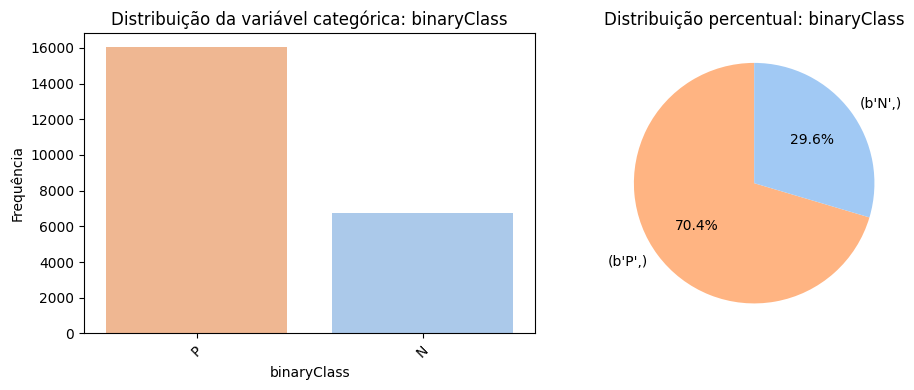

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(data=df, x=categorical_vars[0], hue=categorical_vars[0], palette='pastel', order=df[categorical_vars[0]].value_counts().index, legend=False, ax=ax[0])
ax[0].set_title(f'Distribuição da variável categórica: {categorical_vars[0]}')
ax[0].set_xlabel(categorical_vars[0])
ax[0].set_ylabel('Frequência')
ax[0].tick_params(axis='x', rotation=45)

value_counts = df[categorical_vars].value_counts(dropna=False)
percentages = value_counts / value_counts.sum() * 100

ax[1].pie(
    percentages,
    labels=percentages.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('pastel')[:len(percentages)][::-1],
)
ax[1].set_title(f'Distribuição percentual: {categorical_vars[0]}')

plt.tight_layout()
plt.show()

Vemos acima que há um desbalanceamento entre as classes, o que pode impactar significativamente o desempenho dos modelos de aprendizagem de máquina, em especial para a classe minoritária (Classe $N$, com $29.6\%$).

Visando equilibrar a distribuição das classes, podemos aplicar random over-sampling da classe $N$ ou random under-sampling da classe $P$ ou SMOTE.

---

### Correlação entre as 16 features:

Para verificar e visualiza a matriz de correlação entre as variáveis contínuas, usamos o método `corr()` e `seaborn.heatmap`. As anotações no mapa de calor mostram os coeficientes de correlação par-a-par, ajudando a identificar características altamente correlacionadas.

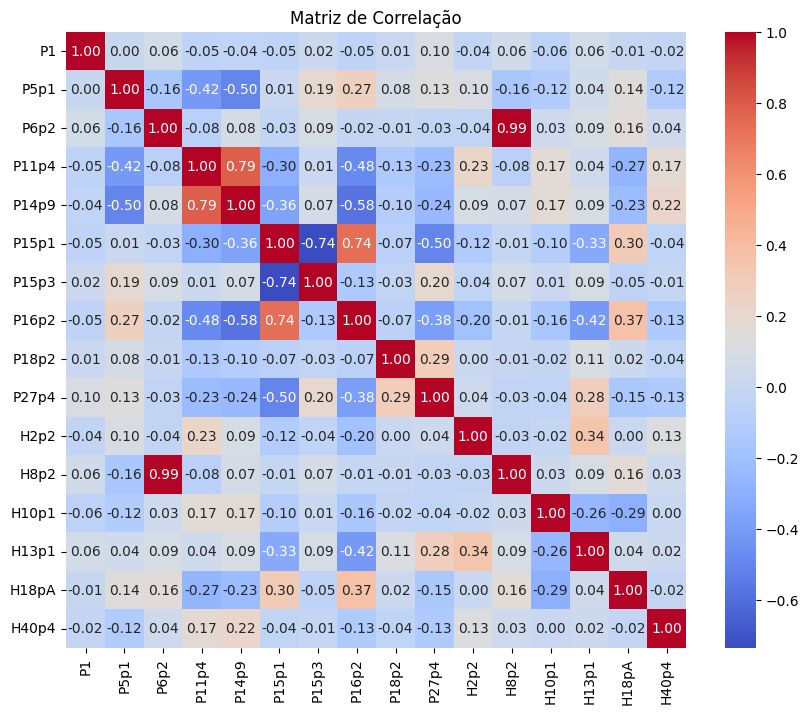

In [ ]:
corr = df[continuous_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

Diante da matriz de correlação acima, temos apenas uma correlação (quer positiva, quer negativa) acima de $0.8$:

- Correlação de $0.99$ entre $P6p2$ e $H8p2$.

A pouca quantidade de correlação indica que não precisamos nos preocupar em remover ou combinar features devido à multicolinearidade.

---

### Dispersão entre as 16 features:

Uma grade de diagramas de dispersão para cada par de variáveis contínuas está mostrado abaixo. Ele fornece uma visão geral das relações entre todos os pares de características contínuas.

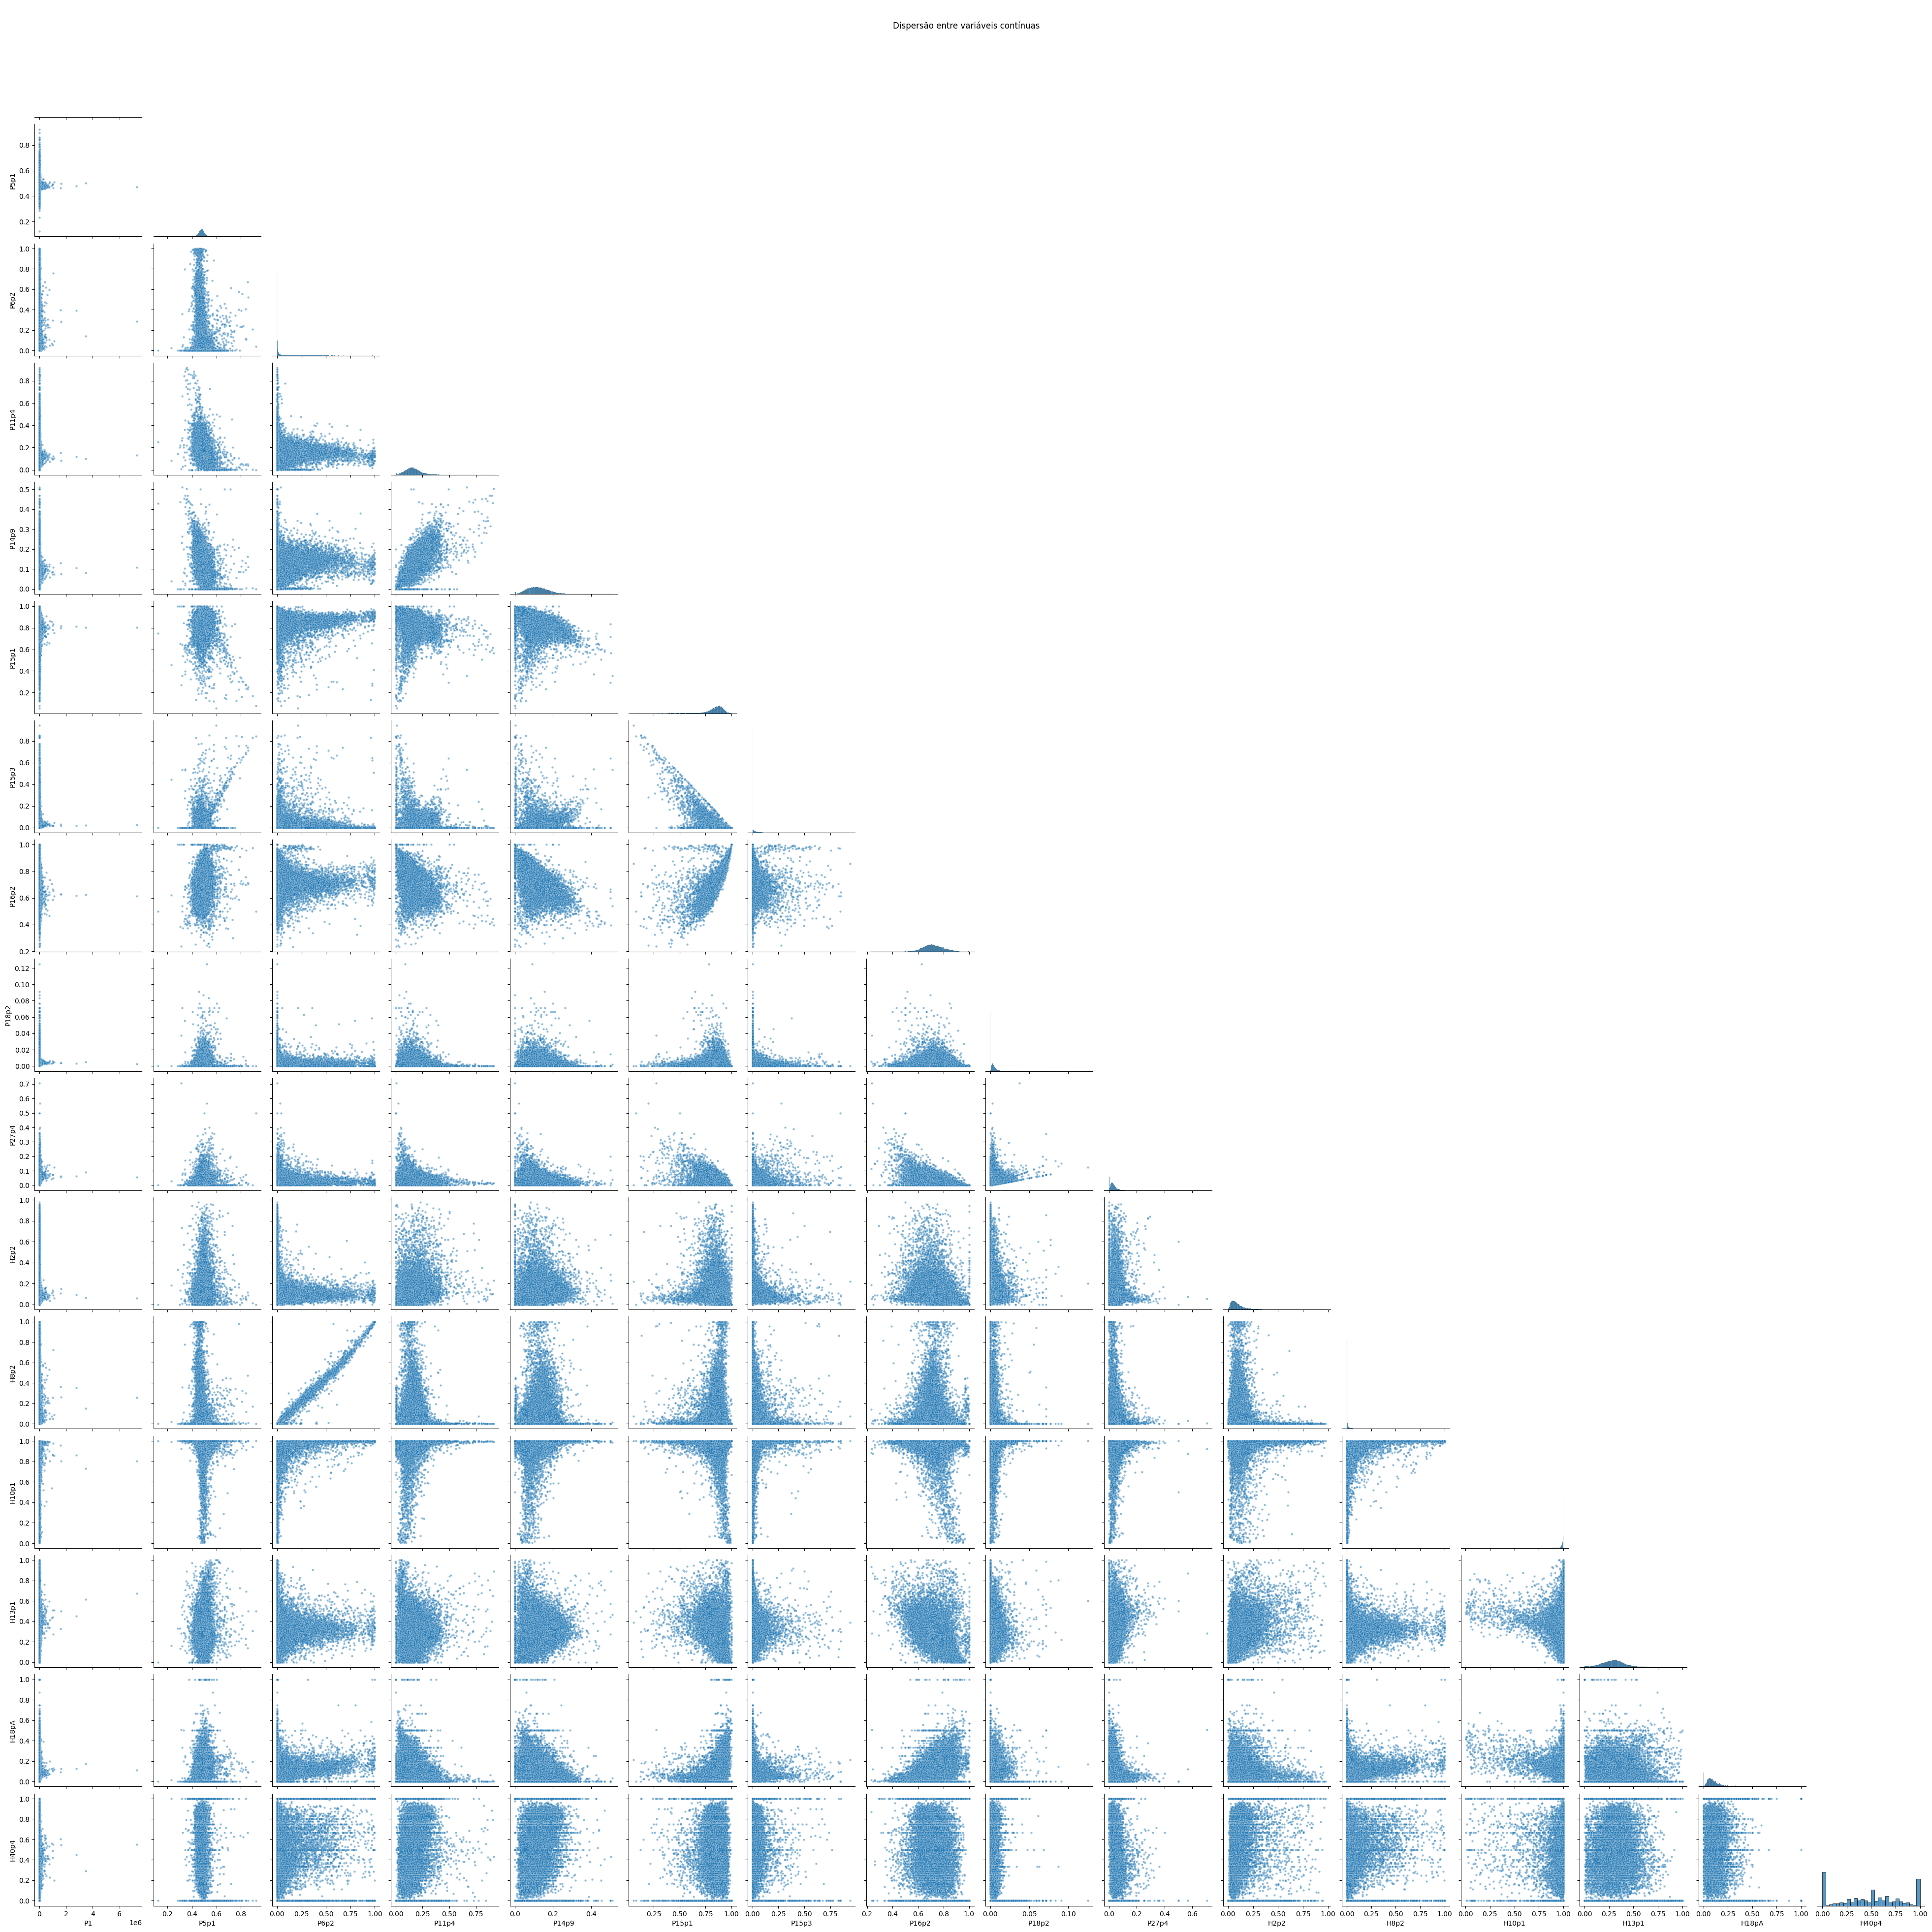

In [ ]:
sns.pairplot(df[continuous_vars], corner=True, plot_kws={'alpha': 0.5, 's': 10})
plt.suptitle("Dispersão entre variáveis contínuas")
plt.show()

Abaixo temos uma seleção de alguns gráficos de dispersão, com pontos coloridos de acordo com sua 'binaryClass'.

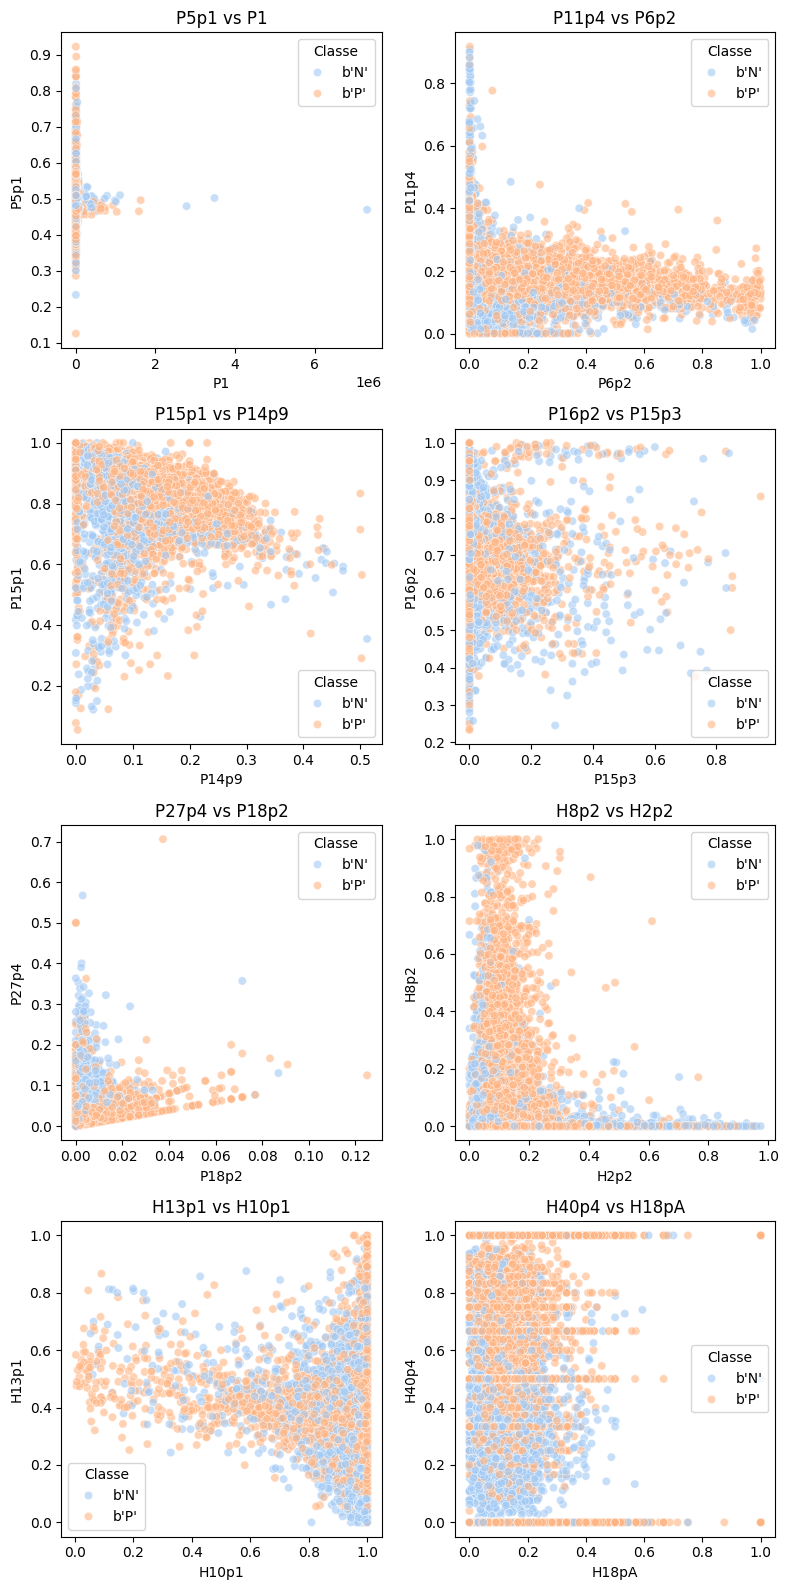

In [ ]:
pairs = [(continuous_vars[i], continuous_vars[i+1]) for i in range(0, len(continuous_vars)-1, 2)]

cols = 2
rows = math.ceil(len(pairs) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

axes = axes.flatten()
for i, (x_var, y_var) in enumerate(pairs):
    sns.scatterplot(data=df, x=x_var, y=y_var, hue=categorical_vars[0], ax=axes[i], palette='pastel', alpha=0.6)
    axes[i].set_title(f'{y_var} vs {x_var}')
    axes[i].legend(title='Classe')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

---

## Preparação dos Dados

### Divisão de subsets utilizando estratificação

Antes de mais nada, é importante dividir o conjunto de dados total em subconjuntos menores para treino, teste e validação. Como iremos também fazer a preparação dos dados, essa etapa preliminar é importante para garantir que não haja vazamento de dados e que o conjunto de testes seja fiel aos dados originais.

- Conjunto de Treinamento: O conjunto de treinamento é utilizado para ensinar o modelo. Ele é usado para ajustar os parâmetros do modelo e permitir que ele aprenda padrões a partir dos dados. No nosso caso, epresenta 70% do total de dados.

- Conjunto de Validação: O conjunto de validação é usado durante o treinamento para monitorar o desempenho do modelo e ajustar hiperparâmetros, como a taxa de aprendizado ou o número de camadas. Ele ajuda a evitar o overfitting. O conjunto de validação representa 15% dos dados.

- Conjunto de Teste: Após o treinamento e validação, o conjunto de teste é utilizado para avaliar o desempenho final do modelo. Ele deve ser totalmente separado dos dados de treinamento e validação para garantir que o modelo não tenha "visto" os dados de teste durante o processo de treinamento. O conjunto de teste também representa 15% dos dados.

Essa divisão ajuda a garantir que o modelo seja treinado de forma robusta e que sua avaliação seja realista, refletindo o desempenho em dados não vistos. Além disso, práticas como a validação cruzada podem ser usadas para obter uma avaliação mais precisa, dividindo os dados em várias partes e treinando e testando o modelo em diferentes combinações dessas divisões.

In [ ]:
X = df.drop(columns=['binaryClass'])
y = df['binaryClass']

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=random_seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=random_seed, stratify=y_val_test)

print("Tamanho do conjunto de treinamento:", X_train.shape)
print("Tamanho do conjunto de validação:", X_val.shape)
print("Tamanho do conjunto de teste:", X_test.shape)

Tamanho do conjunto de treinamento: (15948, 16)
Tamanho do conjunto de validação: (3417, 16)
Tamanho do conjunto de teste: (3418, 16)


---

### Codificação de Variáveis

Como visto na seção acima, a única variável que necessita modificação de tipo é a $binaryClass$, que originalmente está representado como string (object).

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

print("Classes originais:", label_encoder.classes_)
print("Classes codificadas:", label_encoder.transform(label_encoder.classes_))

Classes originais: [b'N' b'P']
Classes codificadas: [0 1]


---

### Reamostragem no conjunto de treinamento

Para equilibrar a distribuição das classes, vamos aplicar o SMOTE no conjunto de treinamento.

In [ ]:
smote = SMOTE(random_state=random_seed)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
print("Distribuição da classe no conjunto de treinamento:\n", pd.Series(y_train).value_counts())

Distribuição da classe no conjunto de treinamento:
 0    11228
1    11228
Name: count, dtype: int64


---

### Remoção de Outliers

Para remover outliers dos dados de treinamento, aplicamos o método z-score com um threshold de 3. Isso removerá as linhas onde qualquer variável contínua tem um z-score absoluto maior que 3.

In [ ]:
z_scores_train = zscore(X_train)
abs_z_scores_train = abs(z_scores_train)
filtered_entries = (abs_z_scores_train < 3).all(axis=1)

X_train_filtered = X_train[filtered_entries]
y_train_filtered = y_train[filtered_entries]

print(f"Tamanho original do conjunto de treinamento: {X_train.shape}")
print(f"Tamanho do conjunto de treinamento após remoção de outliers: {X_train_filtered.shape}")

Tamanho original do conjunto de treinamento: (22456, 16)
Tamanho do conjunto de treinamento após remoção de outliers: (18983, 16)


A fim de avaliarmos a performance dos modelos com diferentes versões de dados, iremos manter versões intermediárias do datset.

---

### Remoção de variáveis com alta correlação

Com base na matriz de correlação, identificamos que as variáveis 'P6p2' e 'H8p2' possuem uma alta correlação (0.99). Para evitar multicolinearidade, vamos remover uma delas. Escolhemos remover a variável 'H8p2'.

Vamos criar novas versões dos conjuntos de dados de treino, validação e teste, tanto para os dados originais quanto para os dados filtrados (sem outliers), removendo a variável 'H8p2'.

In [ ]:
vars_to_remove = ['H8p2']

X_train_no_corr = X_train.drop(columns=vars_to_remove)

X_train_filtered_no_corr = X_train_filtered.drop(columns=vars_to_remove)

print("Tamanho do conjunto de treinamento original com correlação:", X_train.shape)
print("Tamanho do conjunto de treinamento original sem correlação:", X_train_no_corr.shape)
print("Tamanho do conjunto de treinamento filtrado com correlação:", X_train_filtered.shape)
print("Tamanho do conjunto de treinamento filtrado sem correlação:", X_train_filtered_no_corr.shape)

X_val_no_corr = X_val.drop(columns=vars_to_remove)
X_val_no_corr = X_val.drop(columns=vars_to_remove)

X_test_no_corr = X_test.drop(columns=vars_to_remove)
X_test_no_corr = X_test.drop(columns=vars_to_remove)

Tamanho do conjunto de treinamento original com correlação: (22456, 16)
Tamanho do conjunto de treinamento original sem correlação: (22456, 15)
Tamanho do conjunto de treinamento filtrado com correlação: (18983, 16)
Tamanho do conjunto de treinamento filtrado sem correlação: (18983, 15)


---

### Normalizando os subconjuntos

Vamos normalizar as variáveis contínuas nos conjuntos de treinamento, validação e teste usando o `StandardScaler` do scikit-learn. É importante ajustar o scaler apenas nos dados de treinamento para evitar vazamento de dados. Vamos aplicar a normalização em todas as quatro versões dos nossos conjuntos de dados:

1. Conjuntos originais (`X_train`, `X_val`, `X_test`)
2. Conjuntos filtrados (sem outliers) (`X_train_filtered`, `X_val`, `X_test`)
3. Conjuntos originais sem variáveis correlacionadas (`X_train_no_corr`, `X_val_no_corr`, `X_test_no_corr`)
4. Conjuntos filtrados (sem outliers) sem variáveis correlacionadas (`X_train_filtered_no_corr`, `X_val_filtered_no_corr`, `X_test_filtered_no_corr`)

In [ ]:
scaler_original = MinMaxScaler()
X_train_scaled = scaler_original.fit_transform(X_train)

X_val_scaled = scaler_original.transform(X_val)
X_test_scaled = scaler_original.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


scaler_filtered = MinMaxScaler()
X_train_filtered_scaled = scaler_filtered.fit_transform(X_train_filtered)

X_val_filtered_scaled = scaler_filtered.transform(X_val)
X_test_filtered_scaled = scaler_filtered.transform(X_test)

X_train_filtered_scaled = pd.DataFrame(X_train_filtered_scaled, columns=X_train_filtered.columns, index=X_train_filtered.index)
X_val_filtered_scaled = pd.DataFrame(X_val_filtered_scaled, columns=X_val.columns, index=X_val.index)
X_test_filtered_scaled = pd.DataFrame(X_test_filtered_scaled, columns=X_test.columns, index=X_test.index)


scaler_no_corr = MinMaxScaler()
X_train_no_corr_scaled = scaler_no_corr.fit_transform(X_train_no_corr)

X_val_no_corr_scaled = scaler_no_corr.transform(X_val_no_corr)
X_test_no_corr_scaled = scaler_no_corr.transform(X_test_no_corr)

X_train_no_corr_scaled = pd.DataFrame(X_train_no_corr_scaled, columns=X_train_no_corr.columns, index=X_train_no_corr.index)
X_val_no_corr_scaled = pd.DataFrame(X_val_no_corr_scaled, columns=X_val_no_corr.columns, index=X_val_no_corr.index)
X_test_no_corr_scaled = pd.DataFrame(X_test_no_corr_scaled, columns=X_test_no_corr.columns, index=X_test_no_corr.index)


scaler_filtered_no_corr = MinMaxScaler()
X_train_filtered_no_corr_scaled = scaler_filtered_no_corr.fit_transform(X_train_filtered_no_corr)
X_val_filtered_no_corr_scaled = scaler_filtered_no_corr.transform(X_val_no_corr)
X_test_filtered_no_corr_scaled = scaler_filtered_no_corr.transform(X_test_no_corr)

X_train_filtered_no_corr_scaled = pd.DataFrame(X_train_filtered_no_corr_scaled, columns=X_train_filtered_no_corr.columns, index=X_train_filtered_no_corr.index)
X_val_filtered_no_corr_scaled = pd.DataFrame(X_val_filtered_no_corr_scaled, columns=X_val_no_corr.columns, index=X_val_no_corr.index)
X_test_filtered_no_corr_scaled = pd.DataFrame(X_test_filtered_no_corr_scaled, columns=X_test_no_corr.columns, index=X_test_no_corr.index)

In [ ]:
X_train_scaled.head()

P1      P5p1      P6p2     P11p4     P14p9     P15p1     P15p3  \
0  0.000355  0.485319  0.005387  0.232388  0.126039  0.886097  0.000000   
1  0.000167  0.546893  0.004078  0.128940  0.172172  0.822353  0.025940   
2  0.000053  0.479948  0.005102  0.200243  0.236801  0.910996  0.000000   
3  0.004145  0.441598  0.071720  0.160440  0.245331  0.803519  0.048404   
4  0.000028  0.418602  0.000000  0.129787  0.218940  0.914413  0.000000   

      P16p2     P18p2     P27p4      H2p2      H8p2     H10p1     H13p1  \
0  0.733221  0.020440  0.043450  0.106701  0.005111  0.994019  0.104740   
1  0.585439  0.050952  0.063177  0.379503  0.004246  0.848764  0.739541   
2  0.744944  0.000000  0.038040  0.332907  0.000000  1.000000  0.337900   
3  0.594606  0.024008  0.049492  0.084120  0.066105  0.988960  0.398621   
4  0.720436  0.000000  0.018892  0.133218  0.000000  0.986623  0.383721   

      H18pA     H40p4  
0  0.042683  0.363636  
1  0.129412  1.000000  
2  0.129032  0.000000  
3  0.059173  0.453125  
4  0.222222  1.000000

In [ ]:
X_train_scaled.describe().T

count      mean       std  min       25%       50%       75%  max
P1     22456.0  0.001376  0.010221  0.0  0.000079  0.000272  0.000900  1.0
P5p1   22456.0  0.465803  0.038619  0.0  0.445848  0.464772  0.482173  1.0
P6p2   22456.0  0.056320  0.133026  0.0  0.000321  0.006009  0.034558  1.0
P11p4  22456.0  0.170463  0.087644  0.0  0.113518  0.158371  0.211464  1.0
P14p9  22456.0  0.219855  0.106139  0.0  0.144606  0.206129  0.281772  1.0
P15p1  22456.0  0.842538  0.082658  0.0  0.809675  0.856538  0.894069  1.0
P15p3  22456.0  0.021757  0.058486  0.0  0.000000  0.000777  0.020316  1.0
P16p2  22456.0  0.635048  0.114189  0.0  0.563181  0.634963  0.710393  1.0
P18p2  22456.0  0.028939  0.037158  0.0  0.000000  0.022872  0.039832  1.0
P27p4  22456.0  0.053633  0.042299  0.0  0.027784  0.045946  0.069940  1.0
H2p2   22456.0  0.111257  0.113137  0.0  0.046519  0.076894  0.129759  1.0
H8p2   22456.0  0.050558  0.123144  0.0  0.000000  0.004859  0.031060  1.0
H10p1  22456.0  0.963252  0.095861  0.0  0.973560  0.991199  0.997532  1.0
H13p1  22456.0  0.298341  0.134594  0.0  0.210808  0.292868  0.372738  1.0
H18pA  22456.0  0.102889  0.084331  0.0  0.052548  0.083522  0.130719  1.0
H40p4  22456.0  0.461789  0.304842  0.0  0.250000  0.454546  0.666667  1.0

---

## Seleção de Modelos

### K-Nearest Neighbors

KNN (K-Nearest Neighbors) é um algoritmo de aprendizado supervisionado usado para classificação e regressão. Seu funcionamento é baseado na ideia de que dados semelhantes estão próximos uns dos outros em um espaço de características. Para fazer uma previsão, o KNN identifica os k exemplos de treinamento mais próximos do ponto a ser classificado (com base em uma métrica de distância, como a Euclidiana) e decide o resultado com base na maioria (no caso de classificação). É simples, eficaz em muitos cenários e não requer treinamento explícito, mas pode ser computacionalmente caro em grandes conjuntos de dados.

In [ ]:
knn = KNeighborsClassifier()

Definindo o espaço de parâmetros para o K-NN `sklearn.neighbors.KNeighborsClassifier`:

* **n_neighbors:** Número de vizinhos a serem considerados para a designação da classe. Valores ímpares são geralmente utilizados para evitar empates em problemas de classificação binária. Números baixos (como 3 ou 5) podem resultar em modelos mais sensíveis ao ruído, enquanto valores maiores (como 9 ou 11) tendem a suavizar a fronteira de decisão.
* **algorithm:** Algoritmo utilizado para calcular os n vizinhos mais próximos. "auto" Escolhe automaticamente o melhor algoritmo com base nos dados. "ball_tree" e "kd_tree" são eficientes para dados de alta e baixa dimensionalidade, respectivamente. "brute" Calcula todas as distâncias, sendo útil para conjuntos pequenos ou métricas personalizadas. Testar todos garante que se encontre a melhor estratégia de busca para o conjunto de dados.
* **weights:** Pesos a serem considerados no cálculo da vizinhança. "uniform" atribui pesos iguais a todos os vizinhos, enquanto "distance" pondera os votos de acordo com a distância. A escolha pode impactar significativamente a performance, especialmente em conjuntos de dados com ruído ou distribuição desigual.
* **metric:** Métrica de distância utilizada para cálculo dos vizinhos quando weights=distance.

In [ ]:
KNN_parameters = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
    'algorithm': ['auto', 'brute', 'ball_tree', 'kd_tree'],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

### Learning Vector Quantization

LVQ (Learning Vector Quantization) é um algoritmo de aprendizado supervisionado baseado em protótipos, usado principalmente para tarefas de classificação. Ele funciona representando cada classe por um ou mais vetores de referência (protótipos) no espaço das características. Durante o treinamento, esses protótipos são ajustados iterativamente.

In [ ]:
# lvq = GLVQ()

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class LVQ(BaseEstimator, ClassifierMixin):
    def __init__(self, n_prototypes_per_class=1, learning_rate=0.01, n_epochs=100):
        self.n_prototypes_per_class = n_prototypes_per_class
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs

    def _initialize_prototypes(self, X, y):
        classes = np.unique(y)
        prototypes = []
        prototype_labels = []

        for c in classes:
            class_indices = np.where(y == c)[0]
            chosen_indices = np.random.choice(class_indices, self.n_prototypes_per_class, replace=False)
            prototypes.append(X[chosen_indices])
            prototype_labels.extend([c] * self.n_prototypes_per_class)

        self.prototypes_ = np.vstack(prototypes)
        self.prototype_labels_ = np.array(prototype_labels)

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self._initialize_prototypes(X, y)

        for epoch in range(self.n_epochs):
            for xi, yi in zip(X, y):
                distances = np.linalg.norm(self.prototypes_ - xi, axis=1)
                winner_idx = np.argmin(distances)
                winner_label = self.prototype_labels_[winner_idx]

                if winner_label == yi:
                    self.prototypes_[winner_idx] += self.learning_rate * (xi - self.prototypes_[winner_idx])
                else:
                    self.prototypes_[winner_idx] -= self.learning_rate * (xi - self.prototypes_[winner_idx])
        return self

    def predict(self, X):
        X = np.array(X)
        predictions = []
        for xi in X:
            distances = np.linalg.norm(self.prototypes_ - xi, axis=1)
            winner_idx = np.argmin(distances)
            predictions.append(self.prototype_labels_[winner_idx])
        return np.array(predictions)

    def score(self, X, y):
        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X))


custom_lvq = LVQ()

Definindo o espaço de parâmetros para o LVQ `sklvq`:

* **n_prototypes_per_class:** número de protótipos representativos usados por classe para a aprendizagem;

* **learning_rate:** taxa de aprendizado que controla a atualização dos protótipos durante o treinamento;

* **n_epochs:** número de épocas (iterações completas sobre o conjunto de dados) usadas para treinar o modelo.

In [ ]:
# LVQ_parameters = {
#     # "distance_type": ["squared-euclidean", "euclidean"],
#     # "activation_type": ["identity", "sigmoid", "soft+"],
#     # "random_state": [random_seed]
# }

custom_LVQ_parameters = {
    'n_prototypes_per_class': [1, 2, 3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_epochs': [10, 50, 100]
}

### Árvore de Decisão

Árvore de decisão é um algoritmo de aprendizado supervisionado usado para classificação e regressão, que modela decisões em forma de uma estrutura hierárquica semelhante a uma árvore. Cada nó interno representa uma pergunta ou condição sobre uma característica dos dados, os ramos indicam os possíveis resultados dessa condição, e os nós-folha representam a saída final.

In [ ]:
dt = DecisionTreeClassifier()

Definindo o espaço de parâmetros para a Árvore de Decisão `sklearn.tree.DecisionTreeClassifier`:

* **criterion:** Função que mede a qualidade de uma divisão. A comparação entre critérios pode revelar qual gera melhor generalização em determinados tipos de dados.
* **splitter:** Estratégia utilizada para realizar a divisão em cada nó. "best" escolhe a melhor divisão em cada nó com base no critério selecionado. "random" introduz aleatoriedade, o que pode ajudar a evitar overfitting em alguns casos ou melhorar desempenho em dados com ruído.
* **max_depth:** Profundidade máxima da árvore. Limitar a profundidade ajuda a regularizar o modelo e evitar complexidade desnecessária.
* **min_samples_split:** Número mínimo de exemplos para realizar uma divisão num nó. Aumentar esse valor força a árvore a considerar divisões apenas quando há mais exemplos, o que tende a suavizar o modelo e combater o overfitting.
* **min_samples_leaf:** Número mínimo de exemplos para um nó ser uma folha. Valores maiores previnem a criação de folhas com poucos exemplos, o que pode tornar o modelo mais generalizável.
* **max_features:** Número de variáveis que devem ser consideradas para escolher a melhor divisão.
* **ccp_alpha:** Parâmetro de complexidade utilizado no algoritmo de poda Minimal Cost-Complexity Pruning. É um parâmetro que pode ser mais eficaz do que limitar diretamente a profundidade. Testar variações permite encontrar o ponto ideal entre underfitting e overfitting.
* **random_state:** define a semente do gerador de números aleatórios para garantir a reprodutibilidade dos resultados.

In [ ]:
DT_parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 4, 8, 9, 12],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': [None, 2, 4],
    'ccp_alpha': [0.0, 0.001, 0.0001],
    'random_state': [random_seed]
}

### SVM

SVM (Support Vector Machine) é um algoritmo de aprendizado supervisionado amplamente utilizado para tarefas de classificação e, em menor grau, de regressão. Seu objetivo principal é encontrar o hiperplano que melhor separa as classes no espaço das características, maximizando a margem entre os pontos de dados mais próximos de classes opostas, chamados de vetores de suporte. O SVM pode ser linear ou, usando funções de kernel, pode lidar com dados não linearmente separáveis ao projetá-los em espaços de maior dimensão.

In [ ]:
svm = SVC()

Definindo o espaço de parâmetros para o SVM `sklearn.svm.SVC`:

* **C:** parâmetro de regularização. Valores menores (ex: 0.1) promovem uma margem maior, permitindo mais erros (mais generalização). Valores maiores (ex: 10, 100) penalizam mais os erros, podendo gerar overfitting. A faixa escolhida permite observar diferentes níveis de regularização.

* **kernel:** Tipo de função kernel utilizada para transformar os dados em um espaço de maior dimensionalidade. Permite testar diferentes tipos de mapeamento para capturar relações complexas nos dados.

* **degree:** grau do polinômio usado no kernel (apenas para kernel='poly'). Graus maiores aumentam a complexidade da fronteira de decisão, mas também o risco de overfitting.

* **gamma:** coeficiente do kernel para 'rbf', 'poly' e 'sigmoid'. Define o quão longe a influência de um único ponto de treinamento alcança.

* **coef0:** termo independente em  poly' e 'sigmoid'. Controla o impacto da constante na função do kernel.

* **shrinking:** define se deve usar a heurística de encolhimento. Avaliar ambos pode ser útil para grandes conjuntos ou quando o desempenho é sensível à otimização.

* **random_state:** define a semente do gerador de números aleatórios para garantir a reprodutibilidade dos resultados.

In [ ]:
SVM_parameters = {
    'C': loguniform(1e-3, 1e3),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'] + list(loguniform(1e-4, 1e-1).rvs(size=10)),
    'coef0': expon(scale=1.0),
    'shrinking': [True, False],
    'random_state': [random_seed]
}

### Random Forest

Random Forest é um algoritmo de aprendizado supervisionado baseado em conjuntos (ensemble), usado tanto para classificação quanto para regressão. Ele funciona construindo múltiplas árvores de decisão durante o treinamento e combinando suas previsões para obter um resultado mais robusto e preciso. Cada árvore é treinada com uma amostra aleatória dos dados e considera apenas um subconjunto aleatório das variáveis em cada divisão, o que ajuda a reduzir o sobreajuste e aumentar a generalização.

In [ ]:
rf = RandomForestClassifier()

Definindo o espaço de parâmetros para o Random Forest `sklearn.ensemble.RandomForestClassifier`:

* **criterion:** Função que mede a qualidade de uma divisão. A comparação entre critérios pode revelar qual gera melhor generalização em determinados tipos de dados.
* **max_depth:** Profundidade máxima da árvore. Limitar a profundidade ajuda a regularizar o modelo e evitar complexidade desnecessária.
* **min_samples_split:** Número mínimo de exemplos para realizar uma divisão num nó. Aumentar esse valor força a árvore a considerar divisões apenas quando há mais exemplos, o que tende a suavizar o modelo e combater o overfitting.
* **min_samples_leaf:** Número mínimo de exemplos para um nó ser uma folha. Valores maiores previnem a criação de folhas com poucos exemplos, o que pode tornar o modelo mais generalizável.
* **max_leaf_nodes:** Número máximo de folhas. Limita a complexidade das árvores. Útil para criar árvores mais simples, especialmente em bases pequenas.
* **n_estimators:** número de árvores na floresta. Mais árvores geralmente aumentam a estabilidade e precisão, até certo ponto.
* **max_features:** Número de variáveis que devem ser consideradas para escolher a melhor divisão.
* **max_samples (bootstrap=True):** Determina qual fração do dataset original é dado para cada árvore.
* **ccp_alpha:** Parâmetro de complexidade utilizado no algoritmo de poda Minimal Cost-Complexity Pruning. É um parâmetro que pode ser mais eficaz do que limitar diretamente a profundidade. Testar variações permite encontrar o ponto ideal entre underfitting e overfitting.
* **random_state:** define a semente do gerador de números aleatórios para garantir a reprodutibilidade dos resultados.

In [ ]:
RF_parameters = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 200, 400],
    'min_samples_leaf': [1, 25, 50],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 20, 40],
    'n_estimators': [10, 50, 100],
    'max_samples': [None, 0.5, 0.75, 1.0],
    'bootstrap': [True],
    'ccp_alpha': [0.0, 0.01, 0.1],
    'random_state': [random_seed]
}

---

## Busca de Hiperparâmetros

Utilizaremos o RandomizedSearchCV para a busca dos hiperparâmetros:
* Essa função usa por padrão um cross validation de 5-fold;
* **n_iter:** Número de combinações a serem testadas;
* **scoring:** A estratégia de avaliação a cada iteração do cross validation é a f1-score;
* **verbose:** Controla o nível de detalhes exibidos no terminal durante a execução da busca; quanto maior o valor, mais informações são mostradas.

Daqui pra frente vamos utilizar dois conjuntos de treino:
1. O conjunto de treino 1 é o conjunto de treino original com
tratamento de normalização
2. O conjunto de treino 2 é o conjunto de treino com tratamento de normalização, tratamento de correlação e tratamento de outliers

Essa abordagem visa, alem de encontrar o melhor conjunto de hiperparâmetros para cada subconjunto, mostrar o impacto do pre processamento de dados.

### K-NN:

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
knn_random_search_cv = RandomizedSearchCV(
    knn,
    param_distributions=KNN_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)

In [ ]:
knn_random_search_cv.fit(X_train_scaled, y_train)
knn_random_search_cv.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.856) total time=   1.8s
[CV 2/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.863) total time=   1.2s
[CV 3/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.858) total time=   0.9s
[CV 4/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.843) total time=   0.6s
[CV 5/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.859) total time=   0.5s
[CV 1/5] END algorithm=auto, metric=minkowski, n_neighbors=7, weights=uniform;, score=(train=0.880, test=0.854) total time=   0.3s
[CV 2/5] END algorithm=auto, metric=minkowski, n_neighbors=7, weights=uniform;, score=(train=0.881, test=0.861) total time=   0.3s
[

KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')

In [ ]:
knn_random_search_cv_alt = RandomizedSearchCV(
    knn,
    param_distributions=KNN_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)
knn_random_search_cv_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
knn_random_search_cv_alt.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.882) total time=   0.7s
[CV 2/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.873) total time=   0.6s
[CV 3/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.880) total time=   0.6s
[CV 4/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.877) total time=   0.6s
[CV 5/5] END algorithm=kd_tree, metric=euclidean, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.873) total time=   0.7s
[CV 1/5] END algorithm=auto, metric=minkowski, n_neighbors=7, weights=uniform;, score=(train=0.900, test=0.870) total time=   1.0s
[CV 2/5] END algorithm=auto, metric=minkowski, n_neighbors=7, weights=uniform;, score=(train=0.897, test=0.868) total time=   0.7s
[

KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')

### LVQ:

In [ ]:
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# lvq_random_search_cv = RandomizedSearchCV(
#     lvq,
#     param_distributions=LVQ_parameters,
#     n_iter=1,
#     scoring='f1',
#     random_state=random_seed,
#     verbose=3,
#     cv=cv,
#     return_train_score=True
# )

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
custom_lvq_random_search_cv = RandomizedSearchCV(
    custom_lvq,
    param_distributions=custom_LVQ_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)

In [ ]:
# lvq_random_search_cv.fit(X_train_scaled, y_train)
# lvq_random_search_cv.best_estimator_

custom_lvq_random_search_cv.fit(X_train_scaled, y_train)
custom_lvq_random_search_cv.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END learning_rate=0.1, n_epochs=50, n_prototypes_per_class=5;, score=(train=0.166, test=0.154) total time=  13.8s
[CV 2/5] END learning_rate=0.1, n_epochs=50, n_prototypes_per_class=5;, score=(train=0.065, test=0.071) total time=  13.6s
[CV 3/5] END learning_rate=0.1, n_epochs=50, n_prototypes_per_class=5;, score=(train=0.060, test=0.062) total time=  14.0s
[CV 4/5] END learning_rate=0.1, n_epochs=50, n_prototypes_per_class=5;, score=(train=0.120, test=0.115) total time=  14.3s
[CV 5/5] END learning_rate=0.1, n_epochs=50, n_prototypes_per_class=5;, score=(train=0.037, test=0.038) total time=  14.7s
[CV 1/5] END learning_rate=0.01, n_epochs=50, n_prototypes_per_class=1;, score=(train=0.214, test=0.206) total time=  13.9s
[CV 2/5] END learning_rate=0.01, n_epochs=50, n_prototypes_per_class=1;, score=(train=0.182, test=0.184) total time=  13.0s
[CV 3/5] END learning_rate=0.01, n_epochs=50, n_prototypes_per_class=1;, sc

LVQ(learning_rate=0.001, n_epochs=10, n_prototypes_per_class=5)

In [ ]:
custom_lvq_random_search_cv_alt = RandomizedSearchCV(
    custom_lvq,
    param_distributions=custom_LVQ_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)
custom_lvq_random_search_cv_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
custom_lvq_random_search_cv_alt.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END learning_rate=0.1, n_epochs=50, n_prototypes_per_class=5;, score=(train=0.353, test=0.340) total time=  12.2s
[CV 2/5] END learning_rate=0.1, n_epochs=50, n_prototypes_per_class=5;, score=(train=0.333, test=0.328) total time=  12.7s
[CV 3/5] END learning_rate=0.1, n_epochs=50, n_prototypes_per_class=5;, score=(train=0.369, test=0.403) total time=  12.0s
[CV 4/5] END learning_rate=0.1, n_epochs=50, n_prototypes_per_class=5;, score=(train=0.341, test=0.314) total time=  11.2s
[CV 5/5] END learning_rate=0.1, n_epochs=50, n_prototypes_per_class=5;, score=(train=0.305, test=0.315) total time=  12.0s
[CV 1/5] END learning_rate=0.01, n_epochs=50, n_prototypes_per_class=1;, score=(train=0.468, test=0.469) total time=  11.8s
[CV 2/5] END learning_rate=0.01, n_epochs=50, n_prototypes_per_class=1;, score=(train=0.469, test=0.466) total time=  11.2s
[CV 3/5] END learning_rate=0.01, n_epochs=50, n_prototypes_per_class=1;, sc

LVQ(learning_rate=0.001, n_prototypes_per_class=5)

### Árvore de Decisão:

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dt_random_search_cv = RandomizedSearchCV(
    dt,
    param_distributions=DT_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)

In [ ]:
dt_random_search_cv.fit(X_train_scaled, y_train)
dt_random_search_cv.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=4, min_samples_leaf=2, min_samples_split=2, random_state=9, splitter=random;, score=(train=0.716, test=0.695) total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=4, min_samples_leaf=2, min_samples_split=2, random_state=9, splitter=random;, score=(train=0.720, test=0.733) total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=4, min_samples_leaf=2, min_samples_split=2, random_state=9, splitter=random;, score=(train=0.754, test=0.754) total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=4, min_samples_leaf=2, min_samples_split=2, random_state=9, splitter=random;, score=(train=0.725, test=0.714) total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=4, min_samples_leaf=2, min_samples_split=2

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_split=3,
                       random_state=9)

In [ ]:
dt_random_search_cv_alt = RandomizedSearchCV(
    dt,
    param_distributions=DT_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)
dt_random_search_cv_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
dt_random_search_cv_alt.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=4, min_samples_leaf=2, min_samples_split=2, random_state=9, splitter=random;, score=(train=0.797, test=0.780) total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=4, min_samples_leaf=2, min_samples_split=2, random_state=9, splitter=random;, score=(train=0.796, test=0.792) total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=4, min_samples_leaf=2, min_samples_split=2, random_state=9, splitter=random;, score=(train=0.793, test=0.789) total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=4, min_samples_leaf=2, min_samples_split=2, random_state=9, splitter=random;, score=(train=0.783, test=0.762) total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=4, min_samples_leaf=2, min_samples_split=2

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_split=3,
                       random_state=9)

### SVM:

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_random_search_cv = RandomizedSearchCV(
    svm,
    param_distributions=SVM_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)

In [ ]:
svm_random_search_cv.fit(X_train_scaled, y_train)
svm_random_search_cv.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=0.0011541039390580601, coef0=0.6969034106650718, degree=4, gamma=0.0008454242121238581, kernel=sigmoid, random_state=9, shrinking=True;, score=(train=0.601, test=0.610) total time=  21.2s
[CV 2/5] END C=0.0011541039390580601, coef0=0.6969034106650718, degree=4, gamma=0.0008454242121238581, kernel=sigmoid, random_state=9, shrinking=True;, score=(train=0.667, test=0.667) total time=  21.6s
[CV 3/5] END C=0.0011541039390580601, coef0=0.6969034106650718, degree=4, gamma=0.0008454242121238581, kernel=sigmoid, random_state=9, shrinking=True;, score=(train=0.667, test=0.667) total time=  20.9s
[CV 4/5] END C=0.0011541039390580601, coef0=0.6969034106650718, degree=4, gamma=0.0008454242121238581, kernel=sigmoid, random_state=9, shrinking=True;, score=(train=0.000, test=0.000) total time=  20.5s
[CV 5/5] END C=0.0011541039390580601, coef0=0.6969034106650718, degree=4, gamma=0.0008454242121238581, kernel=sigmoid, random_

SVC(C=np.float64(66.44137630116334), coef0=np.float64(4.095900665783436),
    degree=4, gamma='auto', kernel='poly', random_state=9, shrinking=False)

In [ ]:
svm_random_search_cv_alt = RandomizedSearchCV(
    svm,
    param_distributions=SVM_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)
svm_random_search_cv_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
svm_random_search_cv_alt.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=0.0011541039390580601, coef0=0.6969034106650718, degree=4, gamma=0.0008454242121238581, kernel=sigmoid, random_state=9, shrinking=True;, score=(train=0.000, test=0.000) total time=  26.8s
[CV 2/5] END C=0.0011541039390580601, coef0=0.6969034106650718, degree=4, gamma=0.0008454242121238581, kernel=sigmoid, random_state=9, shrinking=True;, score=(train=0.000, test=0.000) total time=  15.6s
[CV 3/5] END C=0.0011541039390580601, coef0=0.6969034106650718, degree=4, gamma=0.0008454242121238581, kernel=sigmoid, random_state=9, shrinking=True;, score=(train=0.000, test=0.000) total time=  15.4s
[CV 4/5] END C=0.0011541039390580601, coef0=0.6969034106650718, degree=4, gamma=0.0008454242121238581, kernel=sigmoid, random_state=9, shrinking=True;, score=(train=0.000, test=0.000) total time=  24.0s
[CV 5/5] END C=0.0011541039390580601, coef0=0.6969034106650718, degree=4, gamma=0.0008454242121238581, kernel=sigmoid, random_

SVC(C=np.float64(66.44137630116334), coef0=np.float64(4.095900665783436),
    degree=4, gamma='auto', kernel='poly', random_state=9, shrinking=False)

### Random Forest:

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_random_search_cv = RandomizedSearchCV(
    rf,
    param_distributions=RF_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)

In [ ]:
rf_random_search_cv.fit(X_train_scaled, y_train)
rf_random_search_cv.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=True, ccp_alpha=0.01, criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=None, max_samples=1.0, min_samples_leaf=25, min_samples_split=2, n_estimators=100, random_state=9;, score=(train=0.847, test=0.836) total time=   6.2s
[CV 2/5] END bootstrap=True, ccp_alpha=0.01, criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=None, max_samples=1.0, min_samples_leaf=25, min_samples_split=2, n_estimators=100, random_state=9;, score=(train=0.845, test=0.848) total time=   5.8s
[CV 3/5] END bootstrap=True, ccp_alpha=0.01, criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=None, max_samples=1.0, min_samples_leaf=25, min_samples_split=2, n_estimators=100, random_state=9;, score=(train=0.844, test=0.845) total time=   6.1s
[CV 4/5] END bootstrap=True, ccp_alpha=0.01, criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=None, max_samples=1.0, min_sample

RandomForestClassifier(criterion='entropy', max_depth=20, max_leaf_nodes=40,
                       max_samples=0.5, min_samples_leaf=50, n_estimators=50,
                       random_state=9)

In [ ]:
rf_random_search_cv_alt = RandomizedSearchCV(
    rf,
    param_distributions=RF_parameters,
    n_iter=20,
    scoring='f1',
    random_state=random_seed,
    verbose=3,
    cv=cv,
    return_train_score=True
)
rf_random_search_cv_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
rf_random_search_cv_alt.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=True, ccp_alpha=0.01, criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=None, max_samples=1.0, min_samples_leaf=25, min_samples_split=2, n_estimators=100, random_state=9;, score=(train=0.847, test=0.841) total time=   3.7s
[CV 2/5] END bootstrap=True, ccp_alpha=0.01, criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=None, max_samples=1.0, min_samples_leaf=25, min_samples_split=2, n_estimators=100, random_state=9;, score=(train=0.846, test=0.849) total time=   3.6s
[CV 3/5] END bootstrap=True, ccp_alpha=0.01, criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=None, max_samples=1.0, min_samples_leaf=25, min_samples_split=2, n_estimators=100, random_state=9;, score=(train=0.848, test=0.848) total time=   4.0s
[CV 4/5] END bootstrap=True, ccp_alpha=0.01, criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=None, max_samples=1.0, min_sample

RandomForestClassifier(criterion='entropy', max_depth=20, max_leaf_nodes=40,
                       max_samples=0.5, min_samples_leaf=50, n_estimators=50,
                       random_state=9)

---

## Monitoramento e Avaliação

### Seleção da Melhor Configuração

Como exposto na seção acima, os modelos foram treinados e avalaiados com base na métrica F1-Score. A partir daqui, avaliaremos mais afundo os modelos que obtiveram melhores resultados.

Conjunto de treino 1:

In [ ]:
best_knn = knn_random_search_cv.best_estimator_
best_lvq = custom_lvq_random_search_cv.best_estimator_
best_dt = dt_random_search_cv.best_estimator_
best_svm = svm_random_search_cv.best_estimator_
best_rf = rf_random_search_cv.best_estimator_

print("Melhor KNN:\n", best_knn)
print("\nMelhor LVQ:\n", best_lvq)
print("\nMelhor Árvore de Decisão:\n", best_dt)
print("\nMelhor SVM:\n", best_svm)
print("\nMelhor Random Forest:\n", best_rf)

Melhor KNN:
 KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')

Melhor LVQ:
 LVQ(learning_rate=0.001, n_epochs=10, n_prototypes_per_class=5)

Melhor Árvore de Decisão:
 DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_split=3,
                       random_state=9)

Melhor SVM:
 SVC(C=np.float64(66.44137630116334), coef0=np.float64(4.095900665783436),
    degree=4, gamma='auto', kernel='poly', random_state=9, shrinking=False)

Melhor Random Forest:
 RandomForestClassifier(criterion='entropy', max_depth=20, max_leaf_nodes=40,
                       max_samples=0.5, min_samples_leaf=50, n_estimators=50,
                       random_state=9)


Conjunto de treino 2:

In [ ]:
best_knn_alt = knn_random_search_cv_alt.best_estimator_
best_lvq_alt = custom_lvq_random_search_cv_alt.best_estimator_
best_dt_alt = dt_random_search_cv_alt.best_estimator_
best_svm_alt = svm_random_search_cv_alt.best_estimator_
best_rf_alt = rf_random_search_cv_alt.best_estimator_

print("Melhor KNN:\n", best_knn_alt)
print("\nMelhor LVQ:\n", best_lvq_alt)
print("\nMelhor Árvore de Decisão:\n", best_dt_alt)
print("\nMelhor SVM:\n", best_svm_alt)
print("\nMelhor Random Forest:\n", best_rf_alt)

Melhor KNN:
 KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')

Melhor LVQ:
 LVQ(learning_rate=0.001, n_prototypes_per_class=5)

Melhor Árvore de Decisão:
 DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_split=3,
                       random_state=9)

Melhor SVM:
 SVC(C=np.float64(66.44137630116334), coef0=np.float64(4.095900665783436),
    degree=4, gamma='auto', kernel='poly', random_state=9, shrinking=False)

Melhor Random Forest:
 RandomForestClassifier(criterion='entropy', max_depth=20, max_leaf_nodes=40,
                       max_samples=0.5, min_samples_leaf=50, n_estimators=50,
                       random_state=9)


---

### Treinamento Final

Conjunto de treino 1:

In [ ]:
final_knn_model = best_knn.fit(X_train_scaled, y_train)
final_lvq_model = best_lvq.fit(X_train_scaled, y_train)
final_dt_model = best_dt.fit(X_train_scaled, y_train)
final_svm_model = best_svm.fit(X_train_scaled, y_train)
final_rf_model = best_rf.fit(X_train_scaled, y_train)

print("Modelos finais treinados.")

Modelos finais treinados.


Conjunto de treino 2:

In [ ]:
final_knn_model_alt = best_knn_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
final_lvq_model_alt = best_lvq_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
final_dt_model_alt = best_dt_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
final_svm_model_alt = best_svm_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)
final_rf_model_alt = best_rf_alt.fit(X_train_filtered_no_corr_scaled, y_train_filtered)

print("Modelos finais treinados.")

Modelos finais treinados.


---

### Avaliação no Conjunto de Teste

Modelos treinados no conjunto de treino 1:

K-NN Evaluation
              precision    recall  f1-score   support

           0       0.69      0.81      0.74      1012
           1       0.91      0.85      0.88      2406

    accuracy                           0.84      3418
   macro avg       0.80      0.83      0.81      3418
weighted avg       0.85      0.84      0.84      3418




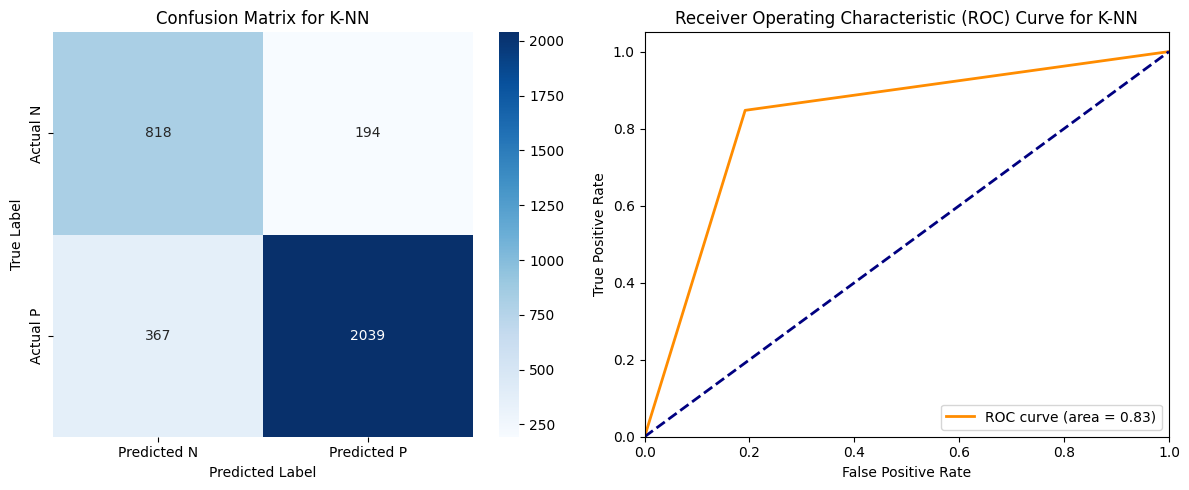

----------------------------------------------------------------------------------------------------

LVQ Evaluation
              precision    recall  f1-score   support

           0       0.48      0.82      0.61      1012
           1       0.89      0.63      0.74      2406

    accuracy                           0.69      3418
   macro avg       0.69      0.73      0.67      3418
weighted avg       0.77      0.69      0.70      3418




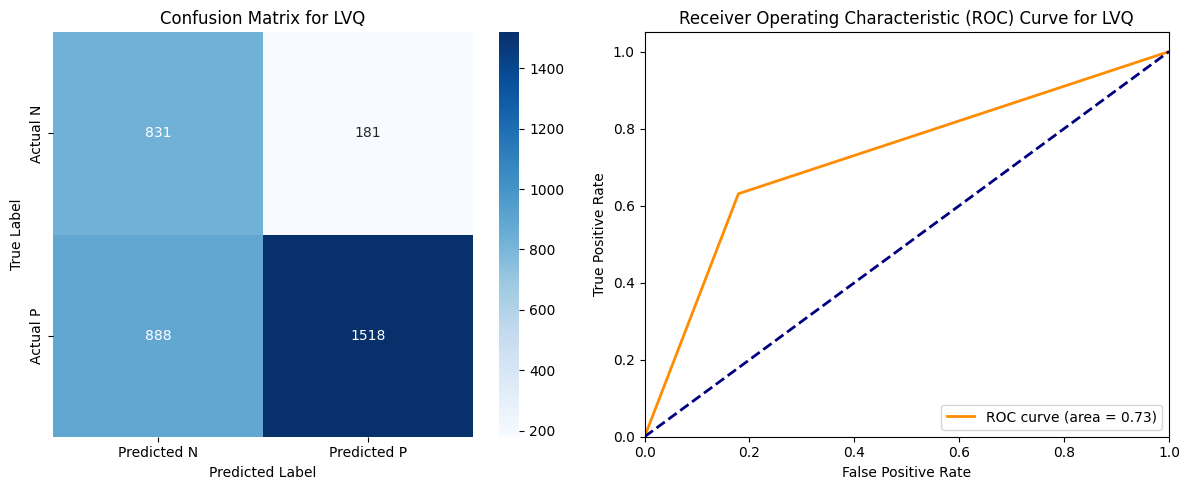

----------------------------------------------------------------------------------------------------

Árvore de Decisão Evaluation
              precision    recall  f1-score   support

           0       0.68      0.82      0.75      1012
           1       0.92      0.84      0.88      2406

    accuracy                           0.83      3418
   macro avg       0.80      0.83      0.81      3418
weighted avg       0.85      0.83      0.84      3418




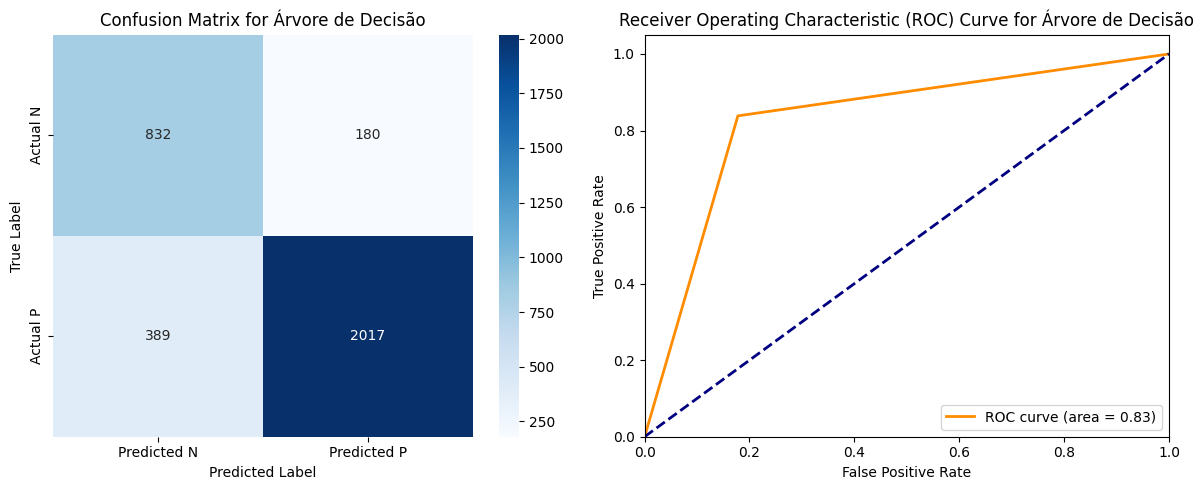

----------------------------------------------------------------------------------------------------

SVM Evaluation
              precision    recall  f1-score   support

           0       0.70      0.84      0.76      1012
           1       0.92      0.85      0.88      2406

    accuracy                           0.84      3418
   macro avg       0.81      0.84      0.82      3418
weighted avg       0.86      0.84      0.85      3418




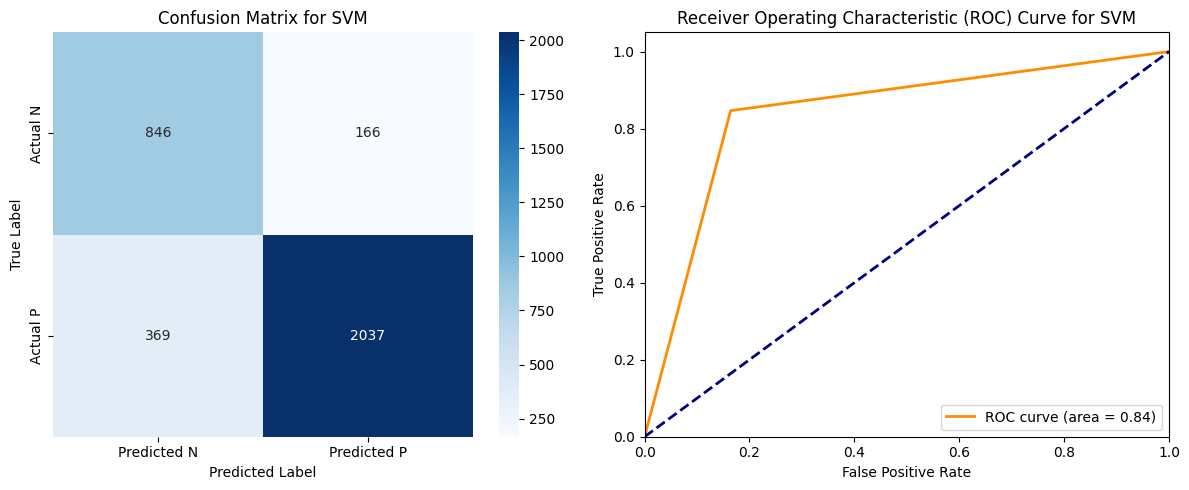

----------------------------------------------------------------------------------------------------

Random Forest Evaluation
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      1012
           1       0.92      0.85      0.89      2406

    accuracy                           0.85      3418
   macro avg       0.81      0.84      0.82      3418
weighted avg       0.86      0.85      0.85      3418




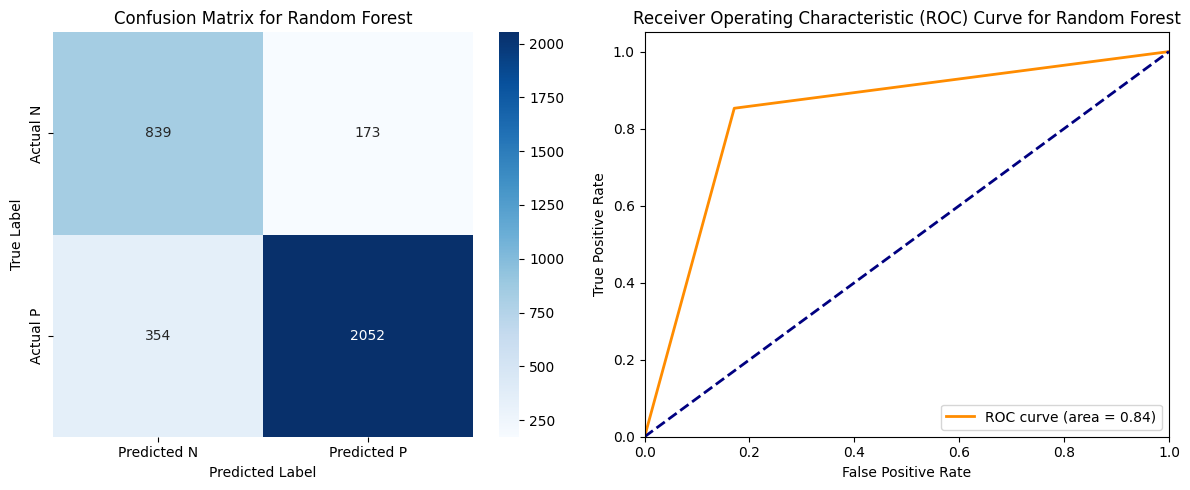

----------------------------------------------------------------------------------------------------



In [ ]:
y_pred_knn = final_knn_model.predict(X_test_scaled)
y_pred_lvq = final_lvq_model.predict(X_test_scaled)
y_pred_dt = final_dt_model.predict(X_test_scaled)
y_pred_svm = final_svm_model.predict(X_test_scaled)
y_pred_rf = final_rf_model.predict(X_test_scaled)

from sklearn.metrics import roc_curve, auc

def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0.0)
    recall = recall_score(y_true, y_pred, zero_division=0.0)
    f1 = f1_score(y_true, y_pred, zero_division=0.0)
    roc_auc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"{model_name} Evaluation")
    print(classification_report(y_true, y_pred, zero_division=0.0))
    print()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted N', 'Predicted P'], yticklabels=['Actual N', 'Actual P'], ax=axes[0])
    axes[0].set_title(f'Confusion Matrix for {model_name}')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
    axes[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()
    print("-" * 100)
    print()


evaluate_model(y_test, y_pred_knn, "K-NN")
evaluate_model(y_test, y_pred_lvq, "LVQ")
evaluate_model(y_test, y_pred_dt, "Árvore de Decisão")
evaluate_model(y_test, y_pred_svm, "SVM")
evaluate_model(y_test, y_pred_rf, "Random Forest")

Modelos treinados no conjunto de treino 2:

K-NN Evaluation
              precision    recall  f1-score   support

           0       0.72      0.82      0.77      1012
           1       0.92      0.87      0.89      2406

    accuracy                           0.85      3418
   macro avg       0.82      0.84      0.83      3418
weighted avg       0.86      0.85      0.86      3418




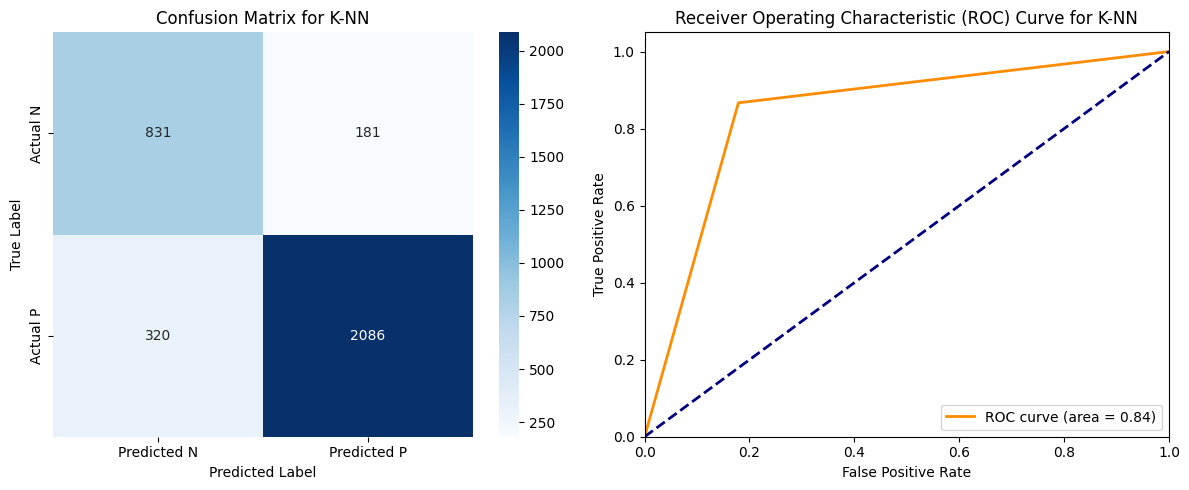

----------------------------------------------------------------------------------------------------

LVQ Evaluation
              precision    recall  f1-score   support

           0       0.57      0.79      0.66      1012
           1       0.89      0.74      0.81      2406

    accuracy                           0.76      3418
   macro avg       0.73      0.77      0.74      3418
weighted avg       0.80      0.76      0.77      3418




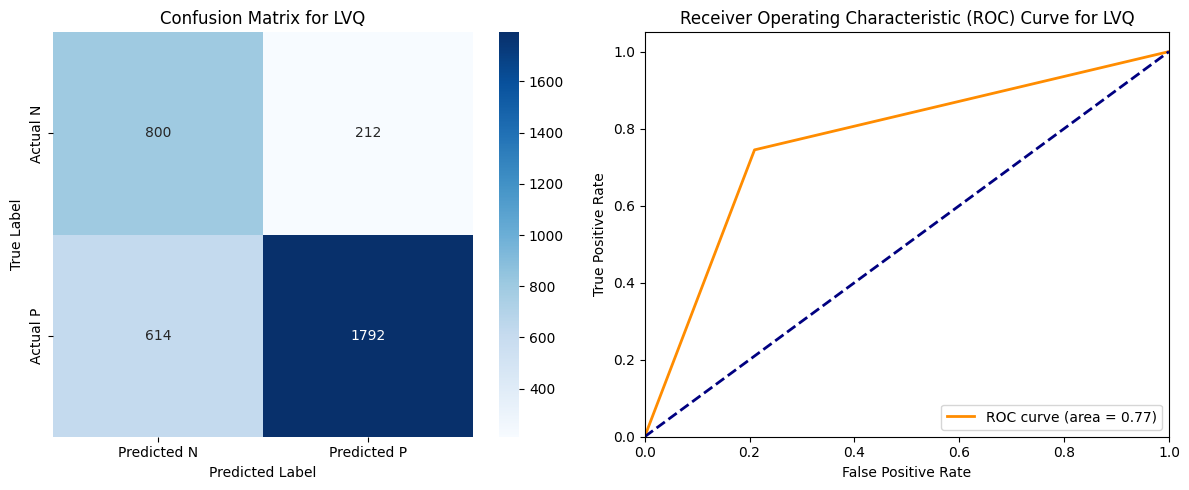

----------------------------------------------------------------------------------------------------

Árvore de Decisão Evaluation
              precision    recall  f1-score   support

           0       0.68      0.85      0.75      1012
           1       0.93      0.83      0.88      2406

    accuracy                           0.83      3418
   macro avg       0.80      0.84      0.81      3418
weighted avg       0.85      0.83      0.84      3418




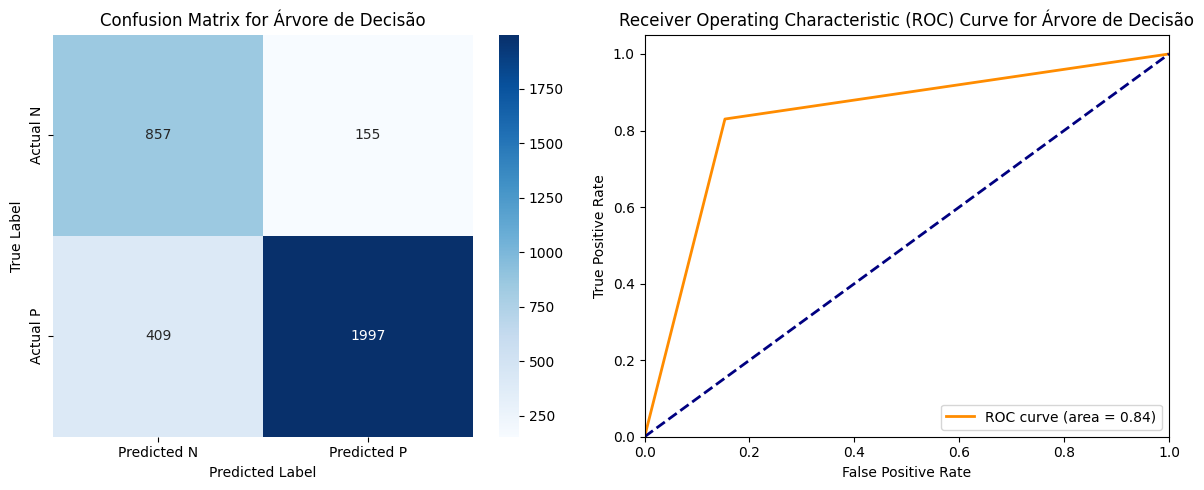

----------------------------------------------------------------------------------------------------

SVM Evaluation
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      1012
           1       0.92      0.87      0.89      2406

    accuracy                           0.85      3418
   macro avg       0.82      0.84      0.83      3418
weighted avg       0.86      0.85      0.86      3418




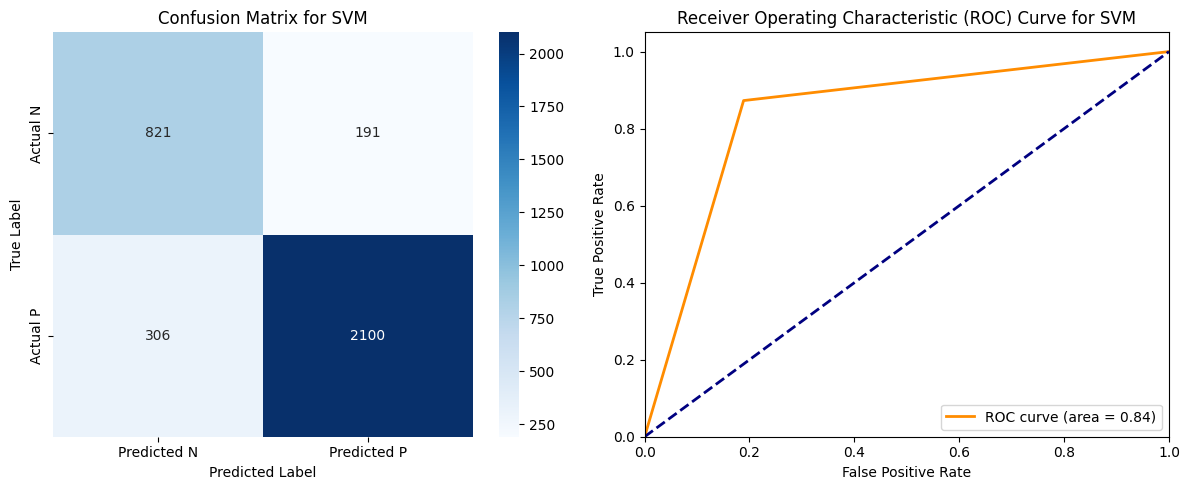

----------------------------------------------------------------------------------------------------

Random Forest Evaluation
              precision    recall  f1-score   support

           0       0.69      0.84      0.76      1012
           1       0.93      0.84      0.88      2406

    accuracy                           0.84      3418
   macro avg       0.81      0.84      0.82      3418
weighted avg       0.86      0.84      0.85      3418




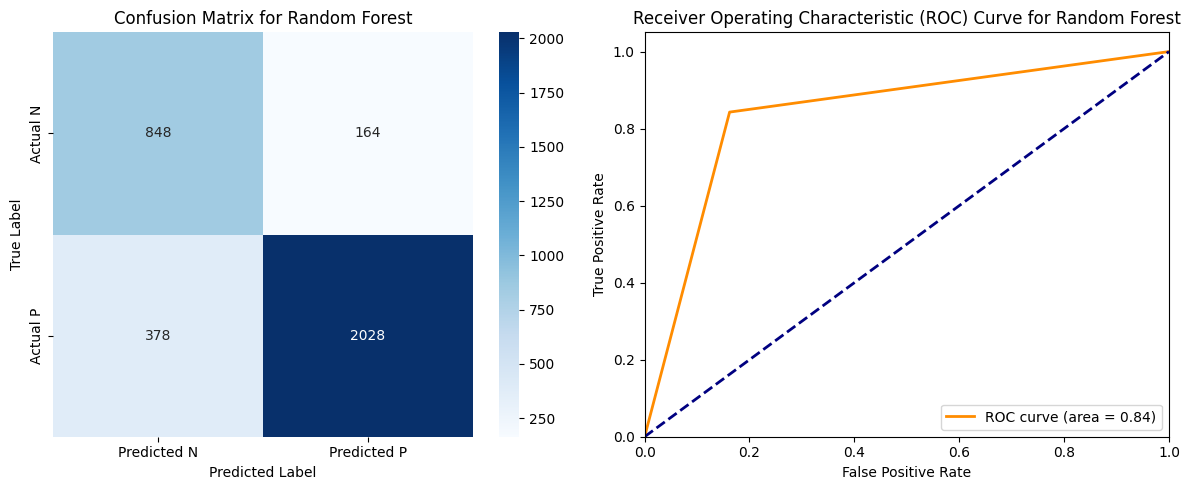

----------------------------------------------------------------------------------------------------



In [ ]:
y_pred_knn_alt = final_knn_model_alt.predict(X_test_filtered_no_corr_scaled)
y_pred_lvq_alt = final_lvq_model_alt.predict(X_test_filtered_no_corr_scaled)
y_pred_dt_alt = final_dt_model_alt.predict(X_test_filtered_no_corr_scaled)
y_pred_svm_alt = final_svm_model_alt.predict(X_test_filtered_no_corr_scaled)
y_pred_rf_alt = final_rf_model_alt.predict(X_test_filtered_no_corr_scaled)

evaluate_model(y_test, y_pred_knn_alt, "K-NN")
evaluate_model(y_test, y_pred_lvq_alt, "LVQ")
evaluate_model(y_test, y_pred_dt_alt, "Árvore de Decisão")
evaluate_model(y_test, y_pred_svm_alt, "SVM")
evaluate_model(y_test, y_pred_rf_alt, "Random Forest")

---

## Comparação e Análise

Com os modelos já avaliados individualmente, iremos, nessa seção, comparar os resultados entre eles. A comparação será feira inicialmente para cada uma das duas versões de dataset utilizadas para o treinamento.

### Comparação de Desempenho


Conjunto de treino 1:

In [ ]:
results = {}

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_pred_knn)
results['K-NN'] = [accuracy_knn, precision_knn, recall_knn, f1_knn, roc_auc_knn]

accuracy_lvq = accuracy_score(y_test, y_pred_lvq)
precision_lvq = precision_score(y_test, y_pred_lvq, zero_division=0.0)
recall_lvq = recall_score(y_test, y_pred_lvq)
f1_lvq = f1_score(y_test, y_pred_lvq)
roc_auc_lvq = roc_auc_score(y_test, y_pred_lvq)
results['LVQ'] = [accuracy_lvq, precision_lvq, recall_lvq, f1_lvq, roc_auc_lvq]

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
results['Árvore de Decisão'] = [accuracy_dt, precision_dt, recall_dt, f1_dt, roc_auc_dt]

accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
results['SVM'] = [accuracy_svm, precision_svm, recall_svm, f1_svm, roc_auc_svm]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
results['Random Forest'] = [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf]


results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']).T

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

results_df.style.apply(highlight_max, axis=0)

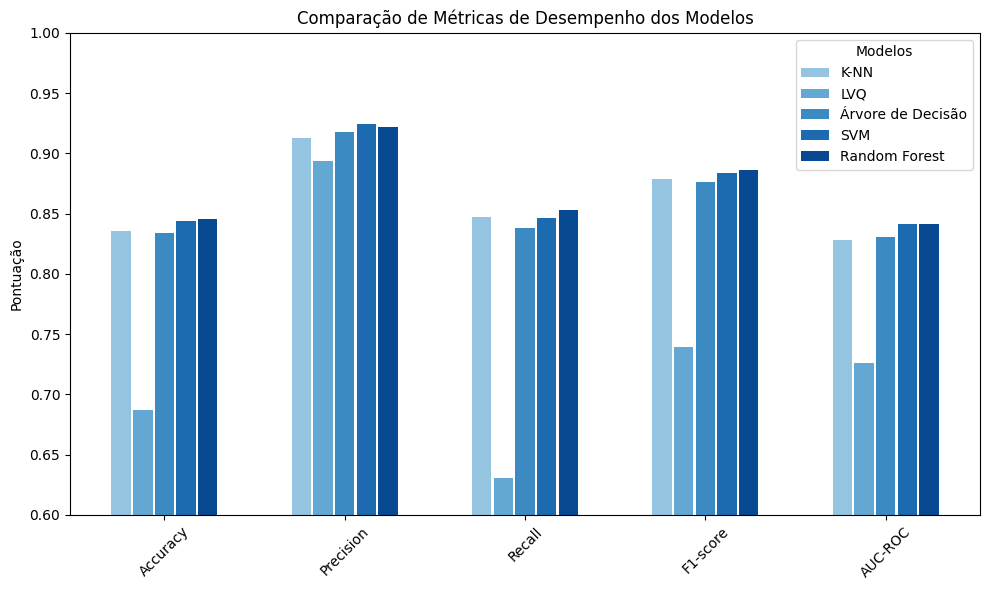

In [ ]:
results_df_T = results_df.T

n_models = results_df_T.shape[1]
bar_width = 0.12
x = np.arange(len(results_df_T.index))

fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.Blues(np.linspace(0.4, 0.9, n_models))

for i, (model_name, color) in enumerate(zip(results_df_T.columns, colors)):
    ax.bar(x + i * bar_width, results_df_T[model_name], width=bar_width * 0.9, label=model_name, color=color)

ax.set_title("Comparação de Métricas de Desempenho dos Modelos")
ax.set_ylabel("Pontuação")
ax.set_xticks(x + bar_width * (n_models - 1) / 2)
ax.set_xticklabels(results_df_T.index, rotation=45)
ax.set_ylim([0.6, 1.0])
ax.legend(title="Modelos")

plt.tight_layout()
plt.show()

Conjunto de treino 2:


In [ ]:
results_alt = {}

accuracy_knn_alt = accuracy_score(y_test, y_pred_knn_alt)
precision_knn_alt = precision_score(y_test, y_pred_knn_alt)
recall_knn_alt = recall_score(y_test, y_pred_knn_alt)
f1_knn_alt = f1_score(y_test, y_pred_knn_alt)
roc_auc_knn_alt = roc_auc_score(y_test, y_pred_knn_alt)
results_alt['K-NN'] = [accuracy_knn_alt, precision_knn_alt, recall_knn_alt, f1_knn_alt, roc_auc_knn_alt]

accuracy_lvq_alt = accuracy_score(y_test, y_pred_lvq_alt)
precision_lvq_alt = precision_score(y_test, y_pred_lvq_alt, zero_division=0.0)
recall_lvq_alt = recall_score(y_test, y_pred_lvq_alt)
f1_lvq_alt = f1_score(y_test, y_pred_lvq_alt)
roc_auc_lvq_alt = roc_auc_score(y_test, y_pred_lvq_alt)
results_alt['LVQ'] = [accuracy_lvq_alt, precision_lvq_alt, recall_lvq_alt, f1_lvq_alt, roc_auc_lvq_alt]

accuracy_dt_alt = accuracy_score(y_test, y_pred_dt_alt)
precision_dt_alt = precision_score(y_test, y_pred_dt_alt)
recall_dt_alt = recall_score(y_test, y_pred_dt_alt)
f1_dt_alt = f1_score(y_test, y_pred_dt_alt)
roc_auc_dt_alt = roc_auc_score(y_test, y_pred_dt_alt)
results_alt['Árvore de Decisão'] = [accuracy_dt_alt, precision_dt_alt, recall_dt_alt, f1_dt_alt, roc_auc_dt_alt]

accuracy_svm_alt = accuracy_score(y_test, y_pred_svm_alt)
precision_svm_alt = precision_score(y_test, y_pred_svm_alt)
recall_svm_alt = recall_score(y_test, y_pred_svm_alt)
f1_svm_alt = f1_score(y_test, y_pred_svm_alt)
roc_auc_svm_alt = roc_auc_score(y_test, y_pred_svm_alt)
results_alt['SVM'] = [accuracy_svm_alt, precision_svm_alt, recall_svm_alt, f1_svm_alt, roc_auc_svm_alt]

accuracy_rf_alt = accuracy_score(y_test, y_pred_rf_alt)
precision_rf_alt = precision_score(y_test, y_pred_rf_alt)
recall_rf_alt = recall_score(y_test, y_pred_rf_alt)
f1_rf_alt = f1_score(y_test, y_pred_rf_alt)
roc_auc_rf_alt = roc_auc_score(y_test, y_pred_rf_alt)
results_alt['Random Forest'] = [accuracy_rf_alt, precision_rf_alt, recall_rf_alt, f1_rf_alt, roc_auc_rf_alt]


results_alt_df = pd.DataFrame(results_alt, index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']).T

results_alt_df.style.apply(highlight_max, axis=0)

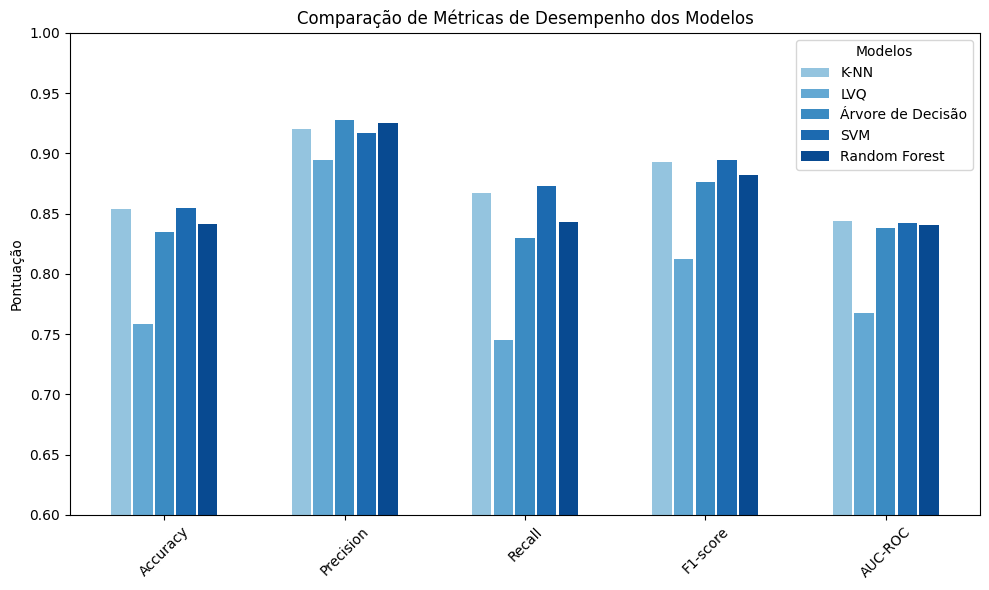

In [ ]:
results_alt_df_T = results_alt_df.T

n_models = results_alt_df_T.shape[1]
bar_width = 0.12
x = np.arange(len(results_alt_df_T.index))

fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.Blues(np.linspace(0.4, 0.9, n_models))

for i, (model_name, color) in enumerate(zip(results_alt_df_T.columns, colors)):
    ax.bar(x + i * bar_width, results_alt_df_T[model_name], width=bar_width * 0.9, label=model_name, color=color)

ax.set_title("Comparação de Métricas de Desempenho dos Modelos")
ax.set_ylabel("Pontuação")
ax.set_xticks(x + bar_width * (n_models - 1) / 2)
ax.set_xticklabels(results_alt_df_T.index, rotation=45)
ax.set_ylim([0.6, 1.0])
ax.legend(title="Modelos")

plt.tight_layout()
plt.show()

---

### Overfitting vs. underfitting


Conjunto de treino 1:

In [ ]:
train_f1_scores = {
    'K-NN': knn_random_search_cv.cv_results_['mean_train_score'][knn_random_search_cv.best_index_],
    'LVQ': custom_lvq_random_search_cv.cv_results_['mean_train_score'][custom_lvq_random_search_cv.best_index_],
    'Árvore de Decisão': dt_random_search_cv.cv_results_['mean_train_score'][dt_random_search_cv.best_index_],
    'SVM': svm_random_search_cv.cv_results_['mean_train_score'][svm_random_search_cv.best_index_],
    'Random Forest': rf_random_search_cv.cv_results_['mean_train_score'][rf_random_search_cv.best_index_]
}

test_f1_scores = {
    'K-NN': f1_knn,
    'LVQ': f1_lvq,
    'Árvore de Decisão': f1_dt,
    'SVM': f1_svm,
    'Random Forest': f1_rf
}

print("Training F1 Scores:")
for model, score in train_f1_scores.items():
    print(f"{model}: {score:.4f}")

print("\nTest F1 Scores:")
for model, score in test_f1_scores.items():
    print(f"{model}: {score:.4f}")

print("\nAnalysis of Overfitting vs. Underfitting:")
for model in train_f1_scores.keys():
    train_score = train_f1_scores[model]
    test_score = test_f1_scores[model]
    difference = train_score - test_score

    print(f"\n{model}:")
    print(f"  Training F1-score: {train_score:.4f}")
    print(f"  Test F1-score: {test_score:.4f}")
    print(f"  Difference (Train - Test): {difference:.4f}")

    if difference > 0.05:
        print("  Conclusion: Potential Overfitting (Training score significantly higher than Test score)")
    elif train_score < 0.7:
         print("  Conclusion: Potential Underfitting (Low training and test scores)")
    else:
        print("  Conclusion: Performing Well (Similar training and test scores)")


Training F1 Scores:
K-NN: 1.0000
LVQ: 0.7698
Árvore de Decisão: 0.9058
SVM: 0.8698
Random Forest: 0.8709

Test F1 Scores:
K-NN: 0.8791
LVQ: 0.7396
Árvore de Decisão: 0.8764
SVM: 0.8839
Random Forest: 0.8862

Analysis of Overfitting vs. Underfitting:

K-NN:
  Training F1-score: 1.0000
  Test F1-score: 0.8791
  Difference (Train - Test): 0.1209
  Conclusion: Potential Overfitting (Training score significantly higher than Test score)

LVQ:
  Training F1-score: 0.7698
  Test F1-score: 0.7396
  Difference (Train - Test): 0.0302
  Conclusion: Performing Well (Similar training and test scores)

Árvore de Decisão:
  Training F1-score: 0.9058
  Test F1-score: 0.8764
  Difference (Train - Test): 0.0294
  Conclusion: Performing Well (Similar training and test scores)

SVM:
  Training F1-score: 0.8698
  Test F1-score: 0.8839
  Difference (Train - Test): -0.0141
  Conclusion: Performing Well (Similar training and test scores)

Random Forest:
  Training F1-score: 0.8709
  Test F1-score: 0.8862
  Dif

Conjunto de treino 2:

In [ ]:
train_f1_scores_alt = {
    'K-NN': knn_random_search_cv_alt.cv_results_['mean_train_score'][knn_random_search_cv_alt.best_index_],
    'LVQ': custom_lvq_random_search_cv_alt.cv_results_['mean_train_score'][custom_lvq_random_search_cv_alt.best_index_],
    'Árvore de Decisão': dt_random_search_cv_alt.cv_results_['mean_train_score'][dt_random_search_cv_alt.best_index_],
    'SVM': svm_random_search_cv_alt.cv_results_['mean_train_score'][svm_random_search_cv_alt.best_index_],
    'Random Forest': rf_random_search_cv_alt.cv_results_['mean_train_score'][rf_random_search_cv_alt.best_index_]
}

test_f1_scores_alt = {
    'K-NN': f1_knn_alt,
    'LVQ': f1_lvq_alt,
    'Árvore de Decisão': f1_dt_alt,
    'SVM': f1_svm_alt,
    'Random Forest': f1_rf_alt
}

print("Training F1 Scores:")
for model, score in train_f1_scores_alt.items():
    print(f"{model}: {score:.4f}")

print("\nTest F1 Scores:")
for model, score in test_f1_scores_alt.items():
    print(f"{model}: {score:.4f}")

print("\nAnalysis of Overfitting vs. Underfitting:")
for model in train_f1_scores_alt.keys():
    train_score = train_f1_scores_alt[model]
    test_score = test_f1_scores_alt[model]
    difference = train_score - test_score

    print(f"\n{model}:")
    print(f"  Training F1-score: {train_score:.4f}")
    print(f"  Test F1-score: {test_score:.4f}")
    print(f"  Difference (Train - Test): {difference:.4f}")

    if difference > 0.05:
        print("  Conclusion: Potential Overfitting (Training score significantly higher than Test score)")
    elif train_score < 0.7:
         print("  Conclusion: Potential Underfitting (Low training and test scores)")
    else:
        print("  Conclusion: Performing Well (Similar training and test scores)")


Training F1 Scores:
K-NN: 1.0000
LVQ: 0.8013
Árvore de Decisão: 0.9116
SVM: 0.8932
Random Forest: 0.8738

Test F1 Scores:
K-NN: 0.8928
LVQ: 0.8127
Árvore de Decisão: 0.8763
SVM: 0.8942
Random Forest: 0.8821

Analysis of Overfitting vs. Underfitting:

K-NN:
  Training F1-score: 1.0000
  Test F1-score: 0.8928
  Difference (Train - Test): 0.1072
  Conclusion: Potential Overfitting (Training score significantly higher than Test score)

LVQ:
  Training F1-score: 0.8013
  Test F1-score: 0.8127
  Difference (Train - Test): -0.0114
  Conclusion: Performing Well (Similar training and test scores)

Árvore de Decisão:
  Training F1-score: 0.9116
  Test F1-score: 0.8763
  Difference (Train - Test): 0.0353
  Conclusion: Performing Well (Similar training and test scores)

SVM:
  Training F1-score: 0.8932
  Test F1-score: 0.8942
  Difference (Train - Test): -0.0010
  Conclusion: Performing Well (Similar training and test scores)

Random Forest:
  Training F1-score: 0.8738
  Test F1-score: 0.8821
  Di

Dentre os modelos analisados, apenas o K-NN apresenta maiores indícios de overfitting, devido à discrepância entre os scores de treino e teste. Os demais modelos exibem diferenças pequenas entre os conjuntos, sugerindo um bom ajuste e capacidade de generalização.

Modelos como SVM e Random Forest se destacam por entregar alto desempenho com controle eficaz de overfitting, sendo boas escolhas para problemas que exigem estabilidade e generalização. Já o K-NN pode requerer ajuste de k, uso de normalização, ou redução de dimensionalidade para mitigar seu comportamento sobreajustado.

---

### Melhores hiperparâmetros


Conjunto de treino 1:

In [ ]:
best_hyperparameters = {
    'K-NN': knn_random_search_cv.best_estimator_.get_params(),
    'LVQ': custom_lvq_random_search_cv.best_estimator_.get_params(),
    'Árvore de Decisão': dt_random_search_cv.best_estimator_.get_params(),
    'SVM': svm_random_search_cv.best_estimator_.get_params(),
    'Random Forest': rf_random_search_cv.best_estimator_.get_params()
}

print("Melhores Hiperparâmetros Encontrados:")
for model, params in best_hyperparameters.items():
    print(f"\n{model}:")
    for param, value in params.items():
        print(f"  {param}: {value}")

Melhores Hiperparâmetros Encontrados:

K-NN:
  algorithm: auto
  leaf_size: 30
  metric: manhattan
  metric_params: None
  n_jobs: None
  n_neighbors: 7
  p: 2
  weights: distance

LVQ:
  learning_rate: 0.001
  n_epochs: 10
  n_prototypes_per_class: 5

Árvore de Decisão:
  ccp_alpha: 0.0
  class_weight: None
  criterion: entropy
  max_depth: 9
  max_features: None
  max_leaf_nodes: None
  min_impurity_decrease: 0.0
  min_samples_leaf: 1
  min_samples_split: 3
  min_weight_fraction_leaf: 0.0
  monotonic_cst: None
  random_state: 9
  splitter: best

SVM:
  C: 66.44137630116334
  break_ties: False
  cache_size: 200
  class_weight: None
  coef0: 4.095900665783436
  decision_function_shape: ovr
  degree: 4
  gamma: auto
  kernel: poly
  max_iter: -1
  probability: False
  random_state: 9
  shrinking: False
  tol: 0.001
  verbose: False

Random Forest:
  bootstrap: True
  ccp_alpha: 0.0
  class_weight: None
  criterion: entropy
  max_depth: 20
  max_features: sqrt
  max_leaf_nodes: 40
  max_

Conjunto de treino 2:

In [ ]:
best_hyperparameters_alt = {
    'K-NN': knn_random_search_cv_alt.best_estimator_.get_params(),
    'LVQ': custom_lvq_random_search_cv_alt.best_estimator_.get_params(),
    'Árvore de Decisão': dt_random_search_cv_alt.best_estimator_.get_params(),
    'SVM': svm_random_search_cv_alt.best_estimator_.get_params(),
    'Random Forest': rf_random_search_cv_alt.best_estimator_.get_params()
}

print("Melhores Hiperparâmetros Encontrados:")
for model, params in best_hyperparameters_alt.items():
    print(f"\n{model}:")
    for param, value in params.items():
        print(f"  {param}: {value}")

Melhores Hiperparâmetros Encontrados:

K-NN:
  algorithm: auto
  leaf_size: 30
  metric: manhattan
  metric_params: None
  n_jobs: None
  n_neighbors: 7
  p: 2
  weights: distance

LVQ:
  learning_rate: 0.001
  n_epochs: 100
  n_prototypes_per_class: 5

Árvore de Decisão:
  ccp_alpha: 0.0
  class_weight: None
  criterion: entropy
  max_depth: 9
  max_features: None
  max_leaf_nodes: None
  min_impurity_decrease: 0.0
  min_samples_leaf: 1
  min_samples_split: 3
  min_weight_fraction_leaf: 0.0
  monotonic_cst: None
  random_state: 9
  splitter: best

SVM:
  C: 66.44137630116334
  break_ties: False
  cache_size: 200
  class_weight: None
  coef0: 4.095900665783436
  decision_function_shape: ovr
  degree: 4
  gamma: auto
  kernel: poly
  max_iter: -1
  probability: False
  random_state: 9
  shrinking: False
  tol: 0.001
  verbose: False

Random Forest:
  bootstrap: True
  ccp_alpha: 0.0
  class_weight: None
  criterion: entropy
  max_depth: 20
  max_features: sqrt
  max_leaf_nodes: 40
  max

* K-NN: O melhor KNN utilizou n_neighbors=7, metric='manhattan', weights='distance'. Um número intermediário de vizinhos (7) pode equilibrar bem entre sensibilidade ao ruído e capacidade de generalização. A métrica 'manhattan' (L1) tende a ser mais robusta a outliers em comparação com a euclidiana (L2), especialmente em espaços de alta dimensionalidade. O uso de weights='distance' atribui maior influência aos vizinhos mais próximos, o que pode melhorar a precisão em regiões densas do espaço de atributos, reduzindo erros causados por vizinhos distantes de outra classe.

* LVQ: O melhor LVQ utilizou learning_rate=0.001, n_epochs=100, n_prototypes_per_class=5. Uma taxa de aprendizado pequena (0.001) garante atualizações suaves nos protótipos, reduzindo a chance de oscilações e instabilidade durante o treinamento. Um número maior de épocas (100) permite que o modelo tenha tempo suficiente para convergir. O uso de múltiplos protótipos por classe (5) oferece maior flexibilidade para representar distribuições complexas, especialmente em classes com alta variabilidade interna.

* Árvore de Decisão: A melhor Árvore de Decisão utilizou max_depth=9, min_samples_leaf=1, min_samples_split=3, criterion='entropy'. A profundidade máxima limitada (9) ajuda a evitar overfitting, restringindo a complexidade da árvore. O uso de min_samples_split=3 permite que a árvore cresça com alguma liberdade, sem ser excessivamente sensível a pequenos grupos de dados. O critério 'entropy' é utilizado para maximizar o ganho de informação em cada divisão, favorecendo separações mais informativas e eficazes.

* SVM: O melhor SVM utilizou C=66.44, kernel='poly', degree=4, gamma='auto', coef0=4.10. Um valor alto de C (66.44) favorece a classificação correta dos dados de treinamento, mesmo que isso leve a margens mais estreitas, aumentando o risco de sobreajuste se não for bem controlado. O kernel polinomial de grau 4 (degree=4) permite que o modelo capture relações altamente não lineares. Os parâmetros gamma='auto' e coef0=4.10 influenciam diretamente a forma das curvas de decisão geradas pelo kernel polinomial, tornando-o mais expressivo e adaptável à complexidade dos dados.

* Random Forest: A melhor Random Forest utilizou n_estimators=50, max_depth=20, max_features='sqrt', min_samples_leaf=50, min_samples_split=2, bootstrap=True, criterion='entropy', max_leaf_nodes=40, max_samples=0.5. A profundidade generosa (20) combinada com um número alto de amostras mínimas por folha (50) ajuda a evitar sobreajuste e força as árvores a aprender padrões mais generalizados. O uso de max_features='sqrt' promove diversidade entre as árvores, reduzindo correlação entre elas. O parâmetro max_leaf_nodes=40 limita o número de folhas, o que ajuda a controlar a complexidade do modelo. O max_samples=0.5 indica que cada árvore foi treinada com apenas metade dos dados disponíveis, o que aumenta a variabilidade entre as árvores. O critério 'entropy' é utilizado para maximizar o ganho de informação em cada divisão, e bootstrap=True garante que cada árvore seja treinada em uma amostra aleatória com reposição dos dados, o que é típico em Random Forests.

## Conclusões


Com base nas métricas de desempenho (Accuracy, Precision, Recall, F1-score e AUC-ROC), os modelos SVM, K-NN e Random Forest apresentaram os melhores resultados no conjunto com pré-processamento, especialmente em termos de F1-score, que mede o equilíbrio entre precisão e sensibilidade (recall).

No conjunto apenas com normalização, o modelo Random Forest obteve um F1-score de 0.8862, seguido por SVM (0.8839) e K-NN (0.8791). Porém, com a aplicação de técnicas como tratamento de correlação e tratamento de outliers, observou-se um ganho consistente de desempenho em quase todos os modelos, com destaque para:

- K-NN, que subiu de 0.8791 para 0.8928 em F1-score;

- SVM, que alcançou o maior F1-score geral, com 0.8942;

- LVQ, que teve um aumento notável de 0.7396 para 0.8127, evidenciando sua sensibilidade ao balanceamento de classes.

### Conclusão Final sobre o Melhor Modelo

Considerando o desempenho geral com pré-processamento (F1-score e AUC-ROC), a pequena diferença entre treino e teste e a estabilidade em diferentes condições de dados, o modelo SVM se destaca como o melhor modelo global, seguido de perto pelo Random Forest.

Ambos demonstram alta capacidade de generalização, mas o SVM, com F1-score ligeiramente superior (0.8942 vs 0.8821), levou vantagem no equilíbrio entre precisão e recall, especialmente após o pré-processamento.

### Implicações dos Resultados:

- O SVM com kernel polinomial foi o modelo mais eficaz, especialmente após pré-processamento, mostrando-se capaz de capturar relações complexas entre as variáveis.

- O Random Forest continua sendo uma alternativa robusta, com desempenho competitivo e fácil interpretabilidade.

- K-NN teve bom desempenho, mas a tendência ao overfitting indica que o modelo é mais sensível à configuração dos dados e à escala dos atributos.

- O modelo LVQ, embora ainda abaixo dos demais, apresentou ganhos notáveis com pré-processamento, mostrando que métodos menos complexos também se beneficiam de técnicas como normalização e reamostragem.

Os resultados nas matrizes de confusão mostram que todos os modelos tiveram mais dificuldade em prever corretamente a classe minoritária ('N' - preço abaixo da média). O Random Forest e o K-NN tiveram o melhor recall para a classe 'N'. As features utilizadas, embora não altamente correlacionadas entre si (exceto P6p2 e H8p2), parecem conter informações discriminativas suficientes para permitir que os modelos atinjam um desempenho razoável. A normalização e o SMOTE ajudaram a lidar com as diferentes escalas das features e o desbalanceamento de classes, respectivamente.

Apesar do bom desempenho, é importante notar que existe espaço para melhoria. Explorar outras técnicas de reamostragem, engenharia de features, ou modelos mais complexos podem potencialmente aumentar o desempenho.
Para aplicação prática, o modelo Random Forest pode ser usado para identificar regiões com maior probabilidade de ter imóveis subvalorizados ou supervalorizados, auxiliando analistas de mercado imobiliário ou investidores.